In [42]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, quantile_transform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_squared_error, r2_score
import joblib

from statsmodels.tsa.vector_ar.var_model import VAR
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, coint
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 7.9 MB/s eta 0:00:00


In [3]:
import koreanize_matplotlib

In [4]:
# Load the provided Excel file
us_file_paths = [
    '/content/미국_서비스_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/미국_소매_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/미국_에너지_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/미국_제조_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
]

india_file_paths = [
    '/content/인도_서비스_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/인도_소매_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/인도_에너지_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/인도_제조_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
]

japan_file_paths = [
    '/content/일본_서비스_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/일본_소매_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/일본_에너지_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/일본_제조_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
]

korea_file_paths = [
    '/content/한국_서비스_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/한국_소매_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/한국_에너지_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/한국_제조_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
]

# 다른 국가 거시지표와 CR 상관계수행렬

In [11]:
us = pd.read_excel(us_file_paths[0])

service = pd.read_excel(india_file_paths[0])
retail = pd.read_excel(india_file_paths[1])
energy = pd.read_excel(india_file_paths[2])
manu = pd.read_excel(india_file_paths[3])

us_gdp = us['gdp성장률']
us_unemploy = us['실업률']

In [13]:
service = service[['Credit_Risk1','Credit_Risk2','Credit_Risk3','Credit_Risk4']]
service['us_gdp'] = us_gdp
service['us_unemploy'] = us_unemploy
print(service.shape[0])
service.corr()

42


,Credit_Risk1,Credit_Risk2,Credit_Risk3,Credit_Risk4,us_gdp,us_unemploy
Credit_Risk1,1.000000,-0.027754,0.335856,0.077499,0.091546,-0.106452
Credit_Risk2,-0.027754,1.000000,0.419377,-0.038079,0.275546,-0.164461
Credit_Risk3,0.335856,0.419377,1.000000,-0.056388,0.056620,-0.156458
Credit_Risk4,0.077499,-0.038079,-0.056388,1.000000,0.061124,-0.191382
us_gdp,0.091546,0.275546,0.056620,0.061124,1.000000,-0.392732
us_unemploy,-0.106452,-0.164461,-0.156458,-0.191382,-0.392732,1.000000


#공적분 검정

In [29]:
for file_path in us_file_paths:
    # Load the provided Excel file
    data = pd.read_excel(file_path)

    # Extract the relevant columns and drop any missing values
    filtered_data = data[['log_gdp', 'log_실업률', 'log_avg_cr']].dropna()

    # Split the data into features (X) and target (y)
    X = filtered_data[['log_gdp', 'log_실업률']]
    y = filtered_data['log_avg_cr']

    # Coint Valuation
    _, pvalue, _ = coint(X['log_gdp'],y)
    # print('Correlation: ' + str(X.corrwith(y)))
    print('GDP Cointegration test p-value: ' + str(pvalue))

    score, pvalue, _ = coint(X['log_실업률'],y)
    # print('Correlation: ' + str(X.corrwith(y)))
    print('실업률 Cointegration test p-value: ' + str(pvalue))

GDP Cointegration test p-value: 0.0019946191403849545
실업률 Cointegration test p-value: 0.05809790230243417
GDP Cointegration test p-value: 0.9859002580259643
실업률 Cointegration test p-value: 0.9859002580259643
GDP Cointegration test p-value: 0.015385896249042191
실업률 Cointegration test p-value: 0.3742672814086743
GDP Cointegration test p-value: 0.00302581592661502
실업률 Cointegration test p-value: 0.25673557398985564


In [37]:
data = pd.read_excel(us_file_paths[1])
# print(data.columns)
data['기간']

0    2019-03-01
1    2019-06-01
2    2019-09-01
3    2019-12-01
4    2020-03-01
5    2020-06-01
6    2020-09-01
7    2020-12-01
8    2021-03-01
9    2021-06-01
10   2021-09-01
11   2021-12-01
12   2022-03-01
13   2022-06-01
14   2022-09-01
15   2022-12-01
16   2023-03-01
17   2023-06-01
18   2023-09-01
19   2023-12-01
Name: 기간, dtype: datetime64[ns]

CR 데이터 정상성 테스트
ADF Statistic: -3.937437216978448
p-value: 0.0017759685664983894
Critical Values 1%: -4.223238279489106
Critical Values 5%: -3.189368925619835
Critical Values 10%: -2.729839421487603

GDP 데이터 정상성 테스트
ADF Statistic: -32.39933539657918
p-value: 0.0
Critical Values 1%: -4.223238279489106
Critical Values 5%: -3.189368925619835
Critical Values 10%: -2.729839421487603

실업률 데이터 정상성 테스트
ADF Statistic: -4.393100277755381
p-value: 0.0003052905863668412
Critical Values 1%: -4.137829282407408
Critical Values 5%: -3.1549724074074077
Critical Values 10%: -2.7144769444444443

공적분 테스트
Cointegration test p-value: 0.9859002580259643

공적분 테스트
Cointegration test p-value: 0.9859002580259643
공적분 관계가 존재하지 않습니다. 차분 데이터를 이용하여 회귀분석을 수행합니다.
                                 OLS Regression Results                                
Dep. Variable:                   d_CR   R-squared (uncentered):                   0.306
Model:                            OLS   Adj. R-squared (uncentered):              0.2

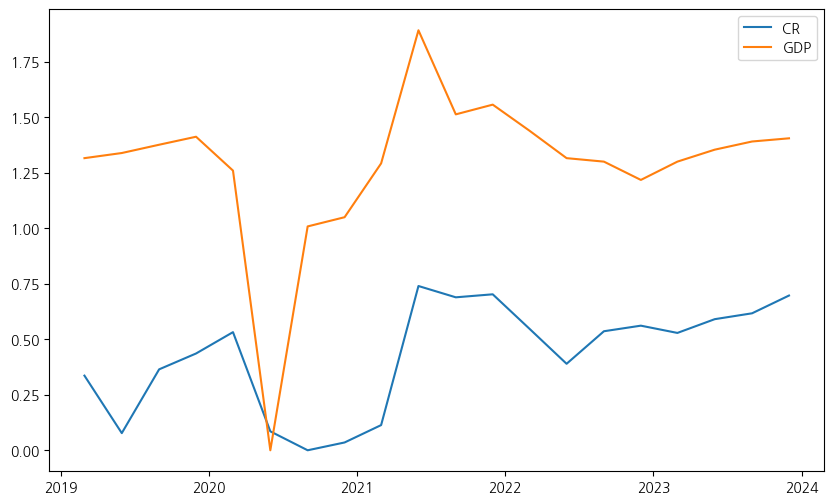

In [39]:
# 데이터 불러오기
# CR 데이터와 GDP 데이터를 포함한 DataFrame을 로드
# data = pd.read_excel('your_data.xlsx')
data = pd.read_excel(us_file_paths[1])

data.index = data['기간']
data = data[['log_gdp', 'log_실업률', 'log_avg_cr']]

# 정상성 테스트 함수
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Values {key}: {value}')
    return result[1]

# 정상성 테스트
print("CR 데이터 정상성 테스트")
p_value_cr = test_stationarity(data['log_avg_cr'])
print("\nGDP 데이터 정상성 테스트")
p_value_gdp = test_stationarity(data['log_gdp'])
print("\n실업률 데이터 정상성 테스트")
p_value_gdp = test_stationarity(data['log_실업률'])

# 공적분 테스트
score, pvalue, _ = coint(data['log_avg_cr'], data['log_gdp'])
print("\n공적분 테스트")
print(f'Cointegration test p-value: {pvalue}')
score, pvalue, _ = coint(data['log_avg_cr'], data['log_실업률'])
print("\n공적분 테스트")
print(f'Cointegration test p-value: {pvalue}')

# 공적분 관계가 존재하면 회귀분석 수행
if pvalue < 0.05:
    print("\n공적분 관계가 존재합니다. 회귀분석을 수행합니다.")

    # 회귀모델 생성
    X = data['log_gdp']
    y = data['log_avg_cr']

    model = OLS(y, X).fit()
    print(model.summary())

    # 잔차의 정상성 테스트
    residuals = model.resid
    print("\n잔차의 정상성 테스트")
    p_value_residuals = test_stationarity(residuals)

    if p_value_residuals < 0.05:
        print("잔차가 정상성을 띄고 있습니다. 공적분 관계가 확인되었습니다.")
    else:
        print("잔차가 정상성을 띄지 않습니다. 공적분 관계가 확인되지 않았습니다.")
else:
    print("공적분 관계가 존재하지 않습니다. 차분 데이터를 이용하여 회귀분석을 수행합니다.")

    # 차분 데이터 생성
    data['d_CR'] = data['log_avg_cr'].diff().dropna()
    data['d_GDP'] = data['log_gdp'].diff().dropna()

    # 차분 데이터로 회귀분석
    X_diff = data['d_GDP'].dropna()
    y_diff = data['d_CR'].dropna()

    model_diff = OLS(y_diff, X_diff).fit()
    print(model_diff.summary())

# 그래프 표시
plt.figure(figsize=(10, 6))
plt.plot(data['log_avg_cr'], label='CR')
plt.plot(data['log_gdp'], label='GDP')
plt.legend()
plt.show()


CR 데이터 정상성 테스트
ADF Statistic: -3.937437216978448
p-value: 0.0017759685664983894
Critical Values 1%: -4.223238279489106
Critical Values 5%: -3.189368925619835
Critical Values 10%: -2.729839421487603

GDP 데이터 정상성 테스트
ADF Statistic: -32.39933539657918
p-value: 0.0
Critical Values 1%: -4.223238279489106
Critical Values 5%: -3.189368925619835
Critical Values 10%: -2.729839421487603

실업률 데이터 정상성 테스트
ADF Statistic: -4.393100277755381
p-value: 0.0003052905863668412
Critical Values 1%: -4.137829282407408
Critical Values 5%: -3.1549724074074077
Critical Values 10%: -2.7144769444444443

공적분 테스트 (log_avg_cr과 log_gdp 간)
Cointegration test p-value: 0.9859002580259643

공적분 테스트 (log_avg_cr과 log_실업률 간)
Cointegration test p-value: 0.9859002580259643
공적분 관계가 존재하지 않습니다. 차분 데이터를 이용하여 회귀분석을 수행합니다. (log_avg_cr ~ log_gdp)
                            OLS Regression Results                            
Dep. Variable:                   d_CR   R-squared:                       0.307
Model:                          

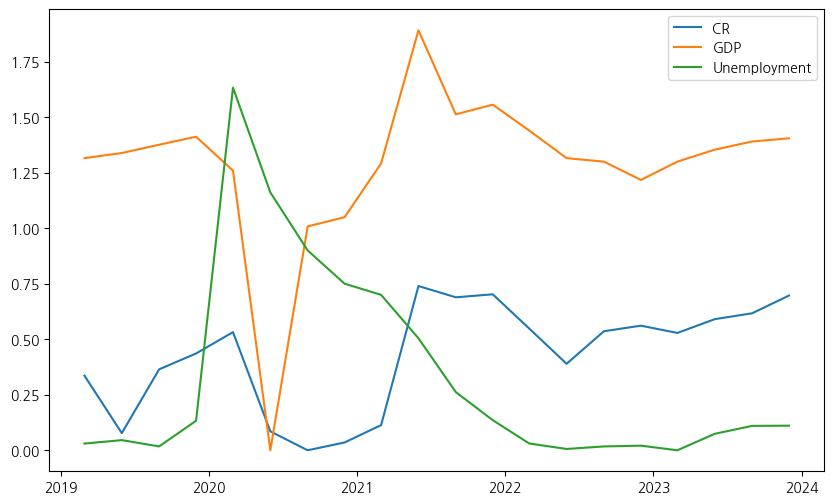

In [43]:
# 데이터 불러오기
data = pd.read_excel(us_file_paths[1])

data.index = data['기간']
data = data[['log_gdp', 'log_실업률', 'log_avg_cr']]

# 정상성 테스트 함수
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Values {key}: {value}')
    return result[1]

# 정상성 테스트
print("CR 데이터 정상성 테스트")
p_value_cr = test_stationarity(data['log_avg_cr'])
print("\nGDP 데이터 정상성 테스트")
p_value_gdp = test_stationarity(data['log_gdp'])
print("\n실업률 데이터 정상성 테스트")
p_value_unemployment = test_stationarity(data['log_실업률'])

# 공적분 테스트 (log_avg_cr과 log_gdp 간)
score, pvalue_gdp, _ = coint(data['log_avg_cr'], data['log_gdp'])
print("\n공적분 테스트 (log_avg_cr과 log_gdp 간)")
print(f'Cointegration test p-value: {pvalue_gdp}')

# 공적분 테스트 (log_avg_cr과 log_실업률 간)
score, pvalue_unemployment, _ = coint(data['log_avg_cr'], data['log_실업률'])
print("\n공적분 테스트 (log_avg_cr과 log_실업률 간)")
print(f'Cointegration test p-value: {pvalue_unemployment}')

# 공적분 관계가 존재하면 회귀분석 수행
if pvalue_gdp < 0.05:
    print("\n공적분 관계가 존재합니다. 회귀분석을 수행합니다. (log_avg_cr ~ log_gdp)")

    # 회귀모델 생성
    X = data['log_gdp']
    y = data['log_avg_cr']

    model = OLS(y, add_constant(X)).fit()
    print(model.summary())

    # 잔차의 정상성 테스트
    residuals = model.resid
    print("\n잔차의 정상성 테스트 (log_avg_cr ~ log_gdp)")
    p_value_residuals = test_stationarity(residuals)

    if p_value_residuals < 0.05:
        print("잔차가 정상성을 띄고 있습니다. 공적분 관계가 확인되었습니다.")
    else:
        print("잔차가 정상성을 띄지 않습니다. 공적분 관계가 확인되지 않았습니다.")
else:
    print("공적분 관계가 존재하지 않습니다. 차분 데이터를 이용하여 회귀분석을 수행합니다. (log_avg_cr ~ log_gdp)")

    # 차분 데이터 생성
    data['d_CR'] = data['log_avg_cr'].diff().dropna()
    data['d_GDP'] = data['log_gdp'].diff().dropna()

    # 차분 데이터로 회귀분석
    X_diff = data['d_GDP'].dropna()
    y_diff = data['d_CR'].dropna()

    model_diff = OLS(y_diff, add_constant(X_diff)).fit()
    print(model_diff.summary())

if pvalue_unemployment < 0.05:
    print("\n공적분 관계가 존재합니다. 회귀분석을 수행합니다. (log_avg_cr ~ log_실업률)")

    # 회귀모델 생성
    X = data['log_실업률']
    y = data['log_avg_cr']

    model = OLS(y, add_constant(X)).fit()
    print(model.summary())

    # 잔차의 정상성 테스트
    residuals = model.resid
    print("\n잔차의 정상성 테스트 (log_avg_cr ~ log_실업률)")
    p_value_residuals = test_stationarity(residuals)

    if p_value_residuals < 0.05:
        print("잔차가 정상성을 띄고 있습니다. 공적분 관계가 확인되었습니다.")
    else:
        print("잔차가 정상성을 띄지 않습니다. 공적분 관계가 확인되지 않았습니다.")
else:
    print("공적분 관계가 존재하지 않습니다. 차분 데이터를 이용하여 회귀분석을 수행합니다. (log_avg_cr ~ log_실업률)")

    # 차분 데이터 생성
    data['d_CR'] = data['log_avg_cr'].diff().dropna()
    data['d_Unemployment'] = data['log_실업률'].diff().dropna()

    # 차분 데이터로 회귀분석
    X_diff = data['d_Unemployment'].dropna()
    y_diff = data['d_CR'].dropna()

    model_diff = OLS(y_diff, add_constant(X_diff)).fit()
    print(model_diff.summary())

# 그래프 표시
plt.figure(figsize=(10, 6))
plt.plot(data['log_avg_cr'], label='CR')
plt.plot(data['log_gdp'], label='GDP')
plt.plot(data['log_실업률'], label='Unemployment')
plt.legend()
plt.show()

Processing file: /content/인도_서비스_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx
CR 데이터 정상성 테스트
ADF Statistic: 1.561222216950671
p-value: 0.9977364476994104
Critical Values 1%: -3.6055648906249997
Critical Values 5%: -2.937069375
Critical Values 10%: -2.606985625

GDP 데이터 정상성 테스트
ADF Statistic: -4.703095802517378
p-value: 8.303310033109573e-05
Critical Values 1%: -3.60098336718852
Critical Values 5%: -2.9351348158036012
Critical Values 10%: -2.6059629803688282

실업률 데이터 정상성 테스트
ADF Statistic: 1.6037906572516678
p-value: 0.9978689036635111
Critical Values 1%: -3.6461350877925254
Critical Values 5%: -2.954126991123355
Critical Values 10%: -2.6159676124885216

공적분 테스트 (log_avg_cr과 log_gdp 간)
Cointegration test p-value: 0.9939209386813257

공적분 테스트 (log_avg_cr과 log_실업률 간)
Cointegration test p-value: 0.3726847736471132
공적분 관계가 존재하지 않습니다. 차분 데이터를 이용하여 회귀분석을 수행합니다. (log_avg_cr ~ log_gdp)
                            OLS Regression Results                            
D

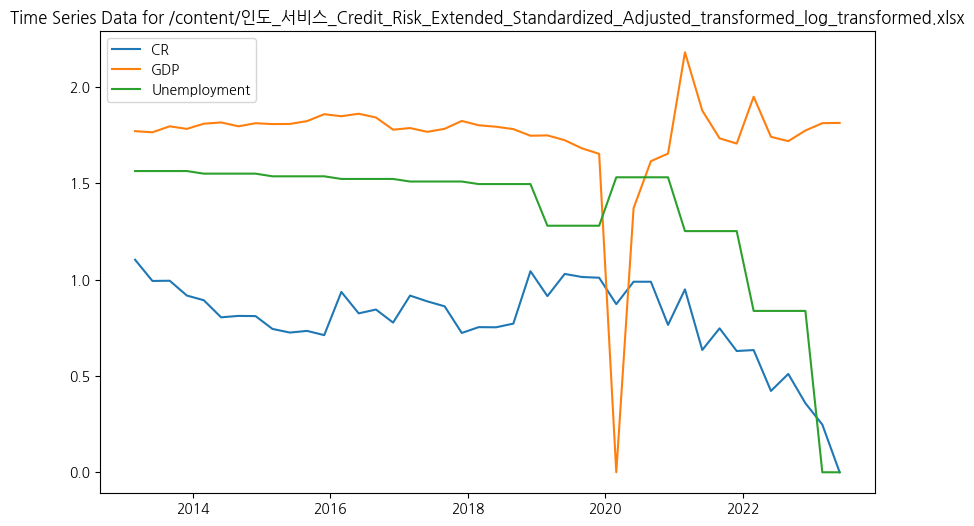

Processing file: /content/인도_소매_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx
CR 데이터 정상성 테스트
ADF Statistic: -3.4794672687691772
p-value: 0.008530344603134921
Critical Values 1%: -3.6461350877925254
Critical Values 5%: -2.954126991123355
Critical Values 10%: -2.6159676124885216

GDP 데이터 정상성 테스트
ADF Statistic: -4.197537392908164
p-value: 0.0006652532684268986
Critical Values 1%: -3.6461350877925254
Critical Values 5%: -2.954126991123355
Critical Values 10%: -2.6159676124885216

실업률 데이터 정상성 테스트
ADF Statistic: 3.0792027869982594
p-value: 1.0
Critical Values 1%: -3.6699197407407405
Critical Values 5%: -2.9640707407407407
Critical Values 10%: -2.621171111111111

공적분 테스트 (log_avg_cr과 log_gdp 간)
Cointegration test p-value: 0.8966030727052291

공적분 테스트 (log_avg_cr과 log_실업률 간)
Cointegration test p-value: 0.009071376916031423
공적분 관계가 존재하지 않습니다. 차분 데이터를 이용하여 회귀분석을 수행합니다. (log_avg_cr ~ log_gdp)
                            OLS Regression Results                          

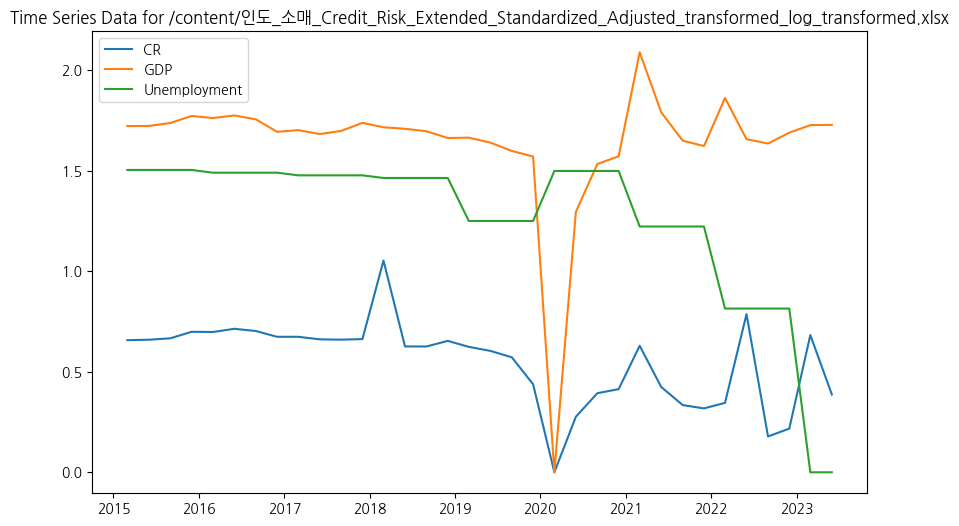

Processing file: /content/인도_에너지_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx
CR 데이터 정상성 테스트
ADF Statistic: -1.663043515084692
p-value: 0.45024704406925303
Critical Values 1%: -3.8326031418574136
Critical Values 5%: -3.0312271701414204
Critical Values 10%: -2.655519584487535

GDP 데이터 정상성 테스트
ADF Statistic: -0.6331738442855773
p-value: 0.8633085497557449
Critical Values 1%: -4.223238279489106
Critical Values 5%: -3.189368925619835
Critical Values 10%: -2.729839421487603

실업률 데이터 정상성 테스트
ADF Statistic: 1182193523750.8003
p-value: 1.0
Critical Values 1%: -4.223238279489106
Critical Values 5%: -3.189368925619835
Critical Values 10%: -2.729839421487603

공적분 테스트 (log_avg_cr과 log_gdp 간)
Cointegration test p-value: 0.9859002580259643

공적분 테스트 (log_avg_cr과 log_실업률 간)
Cointegration test p-value: 0.9859002580259643
공적분 관계가 존재하지 않습니다. 차분 데이터를 이용하여 회귀분석을 수행합니다. (log_avg_cr ~ log_gdp)
                            OLS Regression Results                            
Dep. V

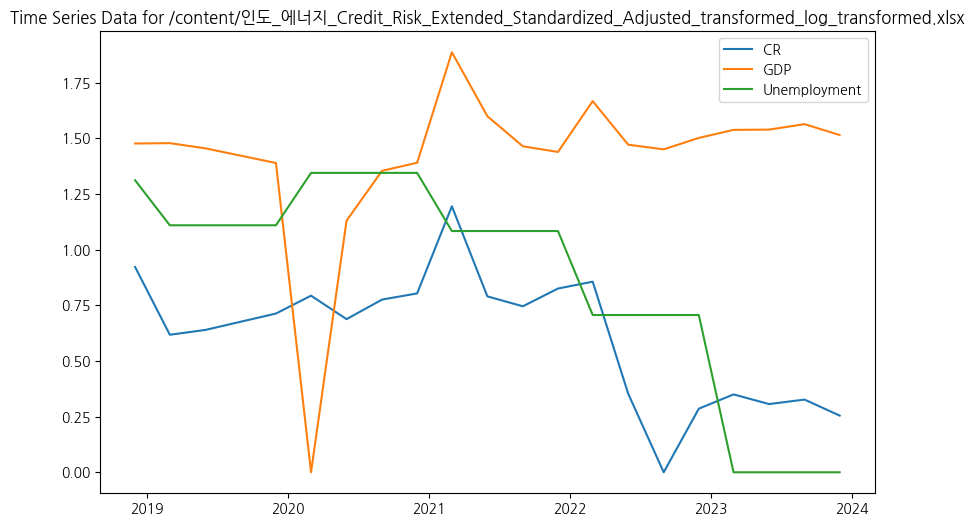

Processing file: /content/인도_제조_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx
CR 데이터 정상성 테스트
ADF Statistic: -2.317224558218589
p-value: 0.1664728708670422
Critical Values 1%: -3.7529275211638033
Critical Values 5%: -2.998499866852963
Critical Values 10%: -2.6389669754253307

GDP 데이터 정상성 테스트
ADF Statistic: -1.873988299085462
p-value: 0.344395013525693
Critical Values 1%: -4.01203360058309
Critical Values 5%: -3.1041838775510207
Critical Values 10%: -2.6909873469387753

실업률 데이터 정상성 테스트
ADF Statistic: 0.2646626167664669
p-value: 0.9756638576180962
Critical Values 1%: -3.9644434814814815
Critical Values 5%: -3.0849081481481484
Critical Values 10%: -2.6818144444444445

공적분 테스트 (log_avg_cr과 log_gdp 간)
Cointegration test p-value: 0.37758694118848257

공적분 테스트 (log_avg_cr과 log_실업률 간)
Cointegration test p-value: 0.004009579900966981
공적분 관계가 존재하지 않습니다. 차분 데이터를 이용하여 회귀분석을 수행합니다. (log_avg_cr ~ log_gdp)
                            OLS Regression Results                 

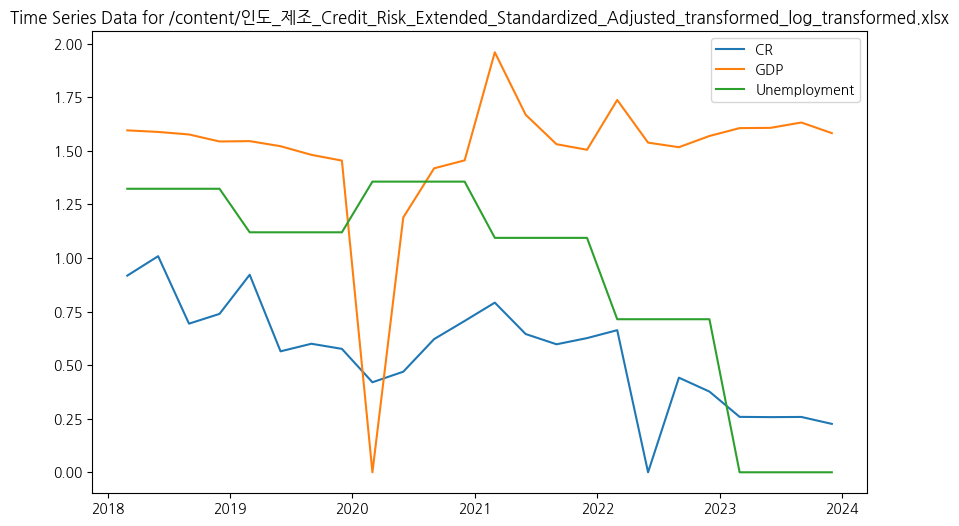

In [44]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Values {key}: {value}')
    return result[1]

for file_path in india_file_paths:
    print(f"Processing file: {file_path}")

    # 데이터 불러오기
    data = pd.read_excel(file_path)
    data.index = data['기간']
    data = data[['log_gdp', 'log_실업률', 'log_avg_cr']]

    # 정상성 테스트
    print("CR 데이터 정상성 테스트")
    p_value_cr = test_stationarity(data['log_avg_cr'])
    print("\nGDP 데이터 정상성 테스트")
    p_value_gdp = test_stationarity(data['log_gdp'])
    print("\n실업률 데이터 정상성 테스트")
    p_value_unemployment = test_stationarity(data['log_실업률'])

    # 공적분 테스트 (log_avg_cr과 log_gdp 간)
    score, pvalue_gdp, _ = coint(data['log_avg_cr'], data['log_gdp'])
    print("\n공적분 테스트 (log_avg_cr과 log_gdp 간)")
    print(f'Cointegration test p-value: {pvalue_gdp}')

    # 공적분 테스트 (log_avg_cr과 log_실업률 간)
    score, pvalue_unemployment, _ = coint(data['log_avg_cr'], data['log_실업률'])
    print("\n공적분 테스트 (log_avg_cr과 log_실업률 간)")
    print(f'Cointegration test p-value: {pvalue_unemployment}')

    # 공적분 관계가 존재하면 회귀분석 수행
    if pvalue_gdp < 0.05:
        print("\n공적분 관계가 존재합니다. 회귀분석을 수행합니다. (log_avg_cr ~ log_gdp)")

        # 회귀모델 생성
        X = data['log_gdp']
        y = data['log_avg_cr']

        model = OLS(y, add_constant(X)).fit()
        print(model.summary())

        # 잔차의 정상성 테스트
        residuals = model.resid
        print("\n잔차의 정상성 테스트 (log_avg_cr ~ log_gdp)")
        p_value_residuals = test_stationarity(residuals)

        if p_value_residuals < 0.05:
            print("잔차가 정상성을 띄고 있습니다. 공적분 관계가 확인되었습니다.")
        else:
            print("잔차가 정상성을 띄지 않습니다. 공적분 관계가 확인되지 않았습니다.")
    else:
        print("공적분 관계가 존재하지 않습니다. 차분 데이터를 이용하여 회귀분석을 수행합니다. (log_avg_cr ~ log_gdp)")

        # 차분 데이터 생성
        data['d_CR'] = data['log_avg_cr'].diff().dropna()
        data['d_GDP'] = data['log_gdp'].diff().dropna()

        # 차분 데이터로 회귀분석
        X_diff = data['d_GDP'].dropna()
        y_diff = data['d_CR'].dropna()

        model_diff = OLS(y_diff, add_constant(X_diff)).fit()
        print(model_diff.summary())

    if pvalue_unemployment < 0.05:
        print("\n공적분 관계가 존재합니다. 회귀분석을 수행합니다. (log_avg_cr ~ log_실업률)")

        # 회귀모델 생성
        X = data['log_실업률']
        y = data['log_avg_cr']

        model = OLS(y, add_constant(X)).fit()
        print(model.summary())

        # 잔차의 정상성 테스트
        residuals = model.resid
        print("\n잔차의 정상성 테스트 (log_avg_cr ~ log_실업률)")
        p_value_residuals = test_stationarity(residuals)

        if p_value_residuals < 0.05:
            print("잔차가 정상성을 띄고 있습니다. 공적분 관계가 확인되었습니다.")
        else:
            print("잔차가 정상성을 띄지 않습니다. 공적분 관계가 확인되지 않았습니다.")
    else:
        print("공적분 관계가 존재하지 않습니다. 차분 데이터를 이용하여 회귀분석을 수행합니다. (log_avg_cr ~ log_실업률)")

        # 차분 데이터 생성
        data['d_CR'] = data['log_avg_cr'].diff().dropna()
        data['d_Unemployment'] = data['log_실업률'].diff().dropna()

        # 차분 데이터로 회귀분석
        X_diff = data['d_Unemployment'].dropna()
        y_diff = data['d_CR'].dropna()

        model_diff = OLS(y_diff, add_constant(X_diff)).fit()
        print(model_diff.summary())

    # 그래프 표시
    plt.figure(figsize=(10, 6))
    plt.plot(data['log_avg_cr'], label='CR')
    plt.plot(data['log_gdp'], label='GDP')
    plt.plot(data['log_실업률'], label='Unemployment')
    plt.legend()
    plt.title(f"Time Series Data for {file_path}")
    plt.show()

# 랜덤포레스트로 CR에 대한 gdp,실업률 각각의 중요도 확인

In [21]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

for file_path in us_file_paths:
    # Load the provided Excel file
    data = pd.read_excel(file_path)

    # Extract the relevant columns and drop any missing values
    filtered_data = data[['log_gdp', 'log_실업률', 'log_avg_cr']].dropna()

    # Split the data into features (X) and target (y)
    X = filtered_data[['log_gdp', 'log_실업률']]
    y = filtered_data['log_avg_cr']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'For dataset {file_path}:')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}\n')

# Save the trained model to a file
# model_filename = 'random_forest_model.pkl'
# joblib.dump(rf, model_filename)
# print(f"Model saved to {model_filename}")

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()

ValueError: y0 is required to have ndim 1 but has ndim 2

For dataset /content/일본_서비스_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx:
Mean Squared Error: 0.02339382597439391
R-squared: 0.3978440331728531

For dataset /content/일본_소매_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx:
Mean Squared Error: 0.053463449160852175
R-squared: -0.40440089690644987

For dataset /content/일본_에너지_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx:
Mean Squared Error: 0.07095769178020447
R-squared: 0.4243394467615591

For dataset /content/일본_제조_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx:
Mean Squared Error: 0.02189043315096053
R-squared: 0.4466404930387513



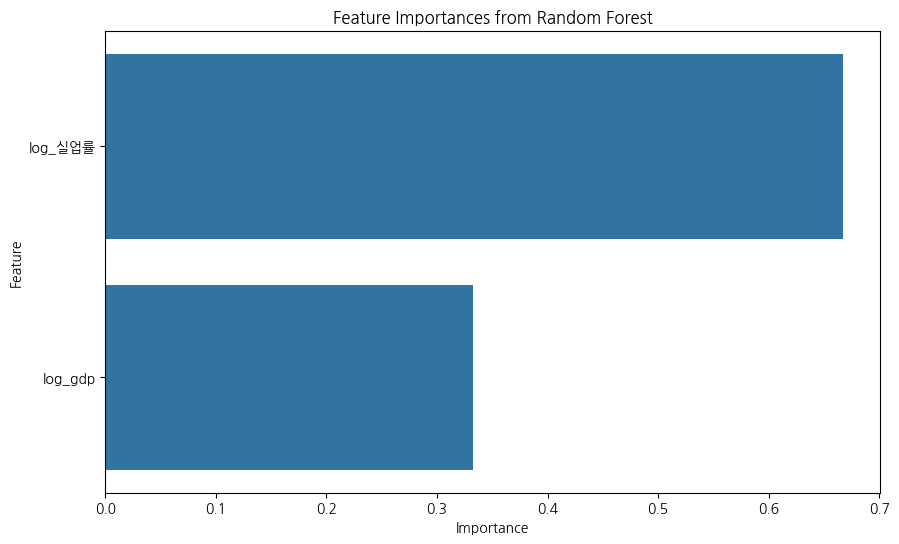

In [16]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

for file_path in japan_file_paths:
    # Load the provided Excel file
    data = pd.read_excel(file_path)

    # Extract the relevant columns and drop any missing values
    filtered_data = data[['log_gdp', 'log_실업률', 'log_avg_cr']].dropna()

    # Split the data into features (X) and target (y)
    X = filtered_data[['log_gdp', 'log_실업률']]
    y = filtered_data['log_avg_cr']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'For dataset {file_path}:')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}\n')

# Save the trained model to a file
# model_filename = 'random_forest_model.pkl'
# joblib.dump(rf, model_filename)
# print(f"Model saved to {model_filename}")

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()

For dataset /content/인도_서비스_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx:
Mean Squared Error: 0.01680264699827259
R-squared: 0.5891202857072713

For dataset /content/인도_소매_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx:
Mean Squared Error: 0.015337420082452993
R-squared: 0.40605850584733283

For dataset /content/인도_에너지_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx:
Mean Squared Error: 0.012162439058570305
R-squared: 0.820629806783902

For dataset /content/인도_제조_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx:
Mean Squared Error: 0.050046702612684554
R-squared: -0.47789129649867745



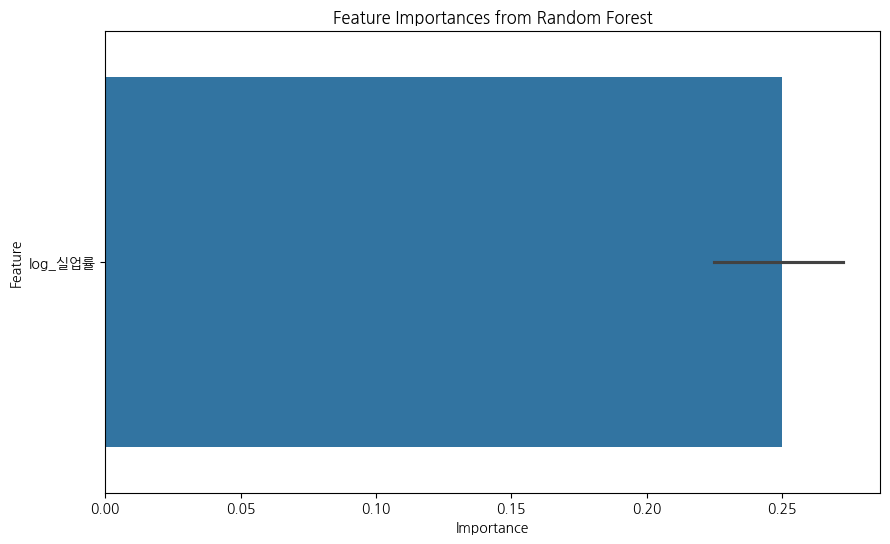

In [17]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

for file_path in india_file_paths:
    # Load the provided Excel file
    data = pd.read_excel(file_path)

    # Extract the relevant columns and drop any missing values
    filtered_data = data[['log_실업률', 'log_실업률', 'log_avg_cr']].dropna()

    # Split the data into features (X) and target (y)
    X = filtered_data[['log_실업률', 'log_실업률']]
    y = filtered_data['log_avg_cr']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'For dataset {file_path}:')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}\n')

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()

For dataset /content/한국_서비스_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx:
Mean Squared Error: 0.07607948316067129
R-squared: -0.8509239093622989

For dataset /content/한국_소매_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx:
Mean Squared Error: 0.08494647291771483
R-squared: -0.02416059488417366

For dataset /content/한국_에너지_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx:
Mean Squared Error: 0.04197156075436539
R-squared: -0.011399505553477907

For dataset /content/한국_제조_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx:
Mean Squared Error: 0.12434673054500496
R-squared: -0.5954987248361359



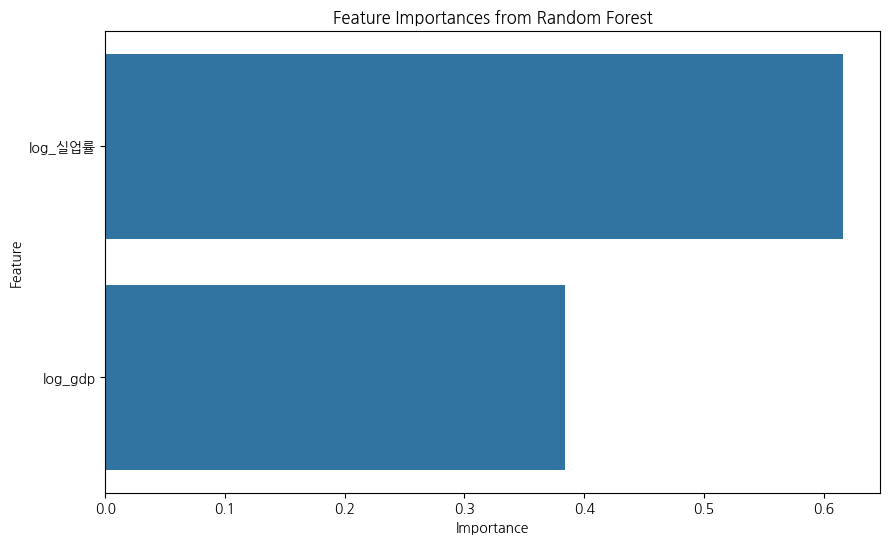

In [18]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

for file_path in korea_file_paths:
    # Load the provided Excel file
    data = pd.read_excel(file_path)

    # Extract the relevant columns and drop any missing values
    filtered_data = data[['log_gdp', 'log_실업률', 'log_avg_cr']].dropna()

    # Split the data into features (X) and target (y)
    X = filtered_data[['log_gdp', 'log_실업률']]
    y = filtered_data['log_avg_cr']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'For dataset {file_path}:')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}\n')

# Save the trained model to a file
# model_filename = 'random_forest_model.pkl'
# joblib.dump(rf, model_filename)
# print(f"Model saved to {model_filename}")

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()

# 모델 로드 후 변수 관계(중요도) 확인

In [8]:
# model_filename = '/content/random_forest_model (1).pkl'
# rf_loaded = joblib.load(model_filename)

file_paths = [
    '/content/미국_서비스_Credit_Risk_Extended_Standardized_Adjusted.xlsx',
    '/content/미국_소매_Credit_Risk_Extended_Standardized_Adjusted.xlsx',
    '/content/미국_에너지_Credit_Risk_Extended_Standardized_Adjusted.xlsx',
    '/content/미국_제조_Credit_Risk_Extended_Standardized_Adjusted.xlsx',
    '/content/인도_서비스_Credit_Risk_Extended_Standardized_Adjusted.xlsx',
    '/content/인도_소매_Credit_Risk_Extended_Standardized_Adjusted.xlsx',
    '/content/인도_에너지_Credit_Risk_Extended_Standardized_Adjusted.xlsx',
    '/content/인도_제조_Credit_Risk_Extended_Standardized_Adjusted.xlsx',
    '/content/일본_서비스_credit_risk_Standardized_Adjusted.xlsx',
    '/content/일본_소매_credit_risk_Standardized_Adjusted.xlsx',
    '/content/일본_에너지_credit_risk_Standardized_Adjusted.xlsx',
    '/content/일본_제조_credit_risk_Standardized_Adjusted.xlsx',
    '/content/한국_서비스_credit_risk_Standardized_Adjusted.xlsx',
    '/content/한국_소매_credit_risk_Standardized_Adjusted.xlsx',
    '/content/한국_에너지_credit_risk_Standardized_Adjusted.xlsx',
    '/content/한국_제조_credit_risk_Standardized_Adjusted.xlsx',
]

# Initialize lists to store results
# mse_list = []
# r2_list = []
# predictions_list = []
rf = RandomForestRegressor(n_estimators=100, random_state=42)

for file_path in file_paths:
    # Load the provided Excel file
    data = pd.read_excel(file_path)

    # Extract the relevant columns and drop any missing values
    filtered_data = data[['gdp성장률', '실업률', 'avg_cr']].dropna()

    # Split the data into features (X) and target (y)
    X = filtered_data[['gdp성장률', '실업률']]
    y = filtered_data['avg_cr']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'For dataset {file_path}:')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}\n')

    # # Predict on the data using the loaded model
    # y_pred_loaded = rf_loaded.predict(X)

    # # Evaluate the model
    # mse_loaded = mean_squared_error(y, y_pred_loaded)
    # r2_loaded = r2_score(y, y_pred_loaded)

    # # Store results
    # mse_list.append(mse_loaded)
    # r2_list.append(r2_loaded)
    # predictions_list.append(y_pred_loaded)

    # Print results for the current dataset
    print(f'For dataset {file_path}:')
    print(f'Mean Squared Error: {mse_loaded}')
    print(f'R-squared: {r2_loaded}\n')

# # Print overall results
# for i, file_path in enumerate(file_paths):
#     print(f'For dataset {file_path}:')
#     print(f'Mean Squared Error: {mse_list[i]}')
#     print(f'R-squared: {r2_list[i]}\n')

For dataset /content/미국_서비스_Credit_Risk_Extended_Standardized_Adjusted.xlsx:
Mean Squared Error: 0.07252748532840247
R-squared: -0.7032444953164452

For dataset /content/미국_서비스_Credit_Risk_Extended_Standardized_Adjusted.xlsx:
Mean Squared Error: 782892.5950771908
R-squared: -4569545.906593139

For dataset /content/미국_소매_Credit_Risk_Extended_Standardized_Adjusted.xlsx:
Mean Squared Error: 0.08142341789233379
R-squared: 0.04834951280991817

For dataset /content/미국_소매_Credit_Risk_Extended_Standardized_Adjusted.xlsx:
Mean Squared Error: 782892.5950771908
R-squared: -4569545.906593139

For dataset /content/미국_에너지_Credit_Risk_Extended_Standardized_Adjusted.xlsx:
Mean Squared Error: 0.06430534415735012
R-squared: -0.6185260659099527

For dataset /content/미국_에너지_Credit_Risk_Extended_Standardized_Adjusted.xlsx:
Mean Squared Error: 782892.5950771908
R-squared: -4569545.906593139

For dataset /content/미국_제조_Credit_Risk_Extended_Standardized_Adjusted.xlsx:
Mean Squared Error: 0.16607427523004717
R

# 실패한 구조적 VAR

<Figure size 1000x600 with 0 Axes>

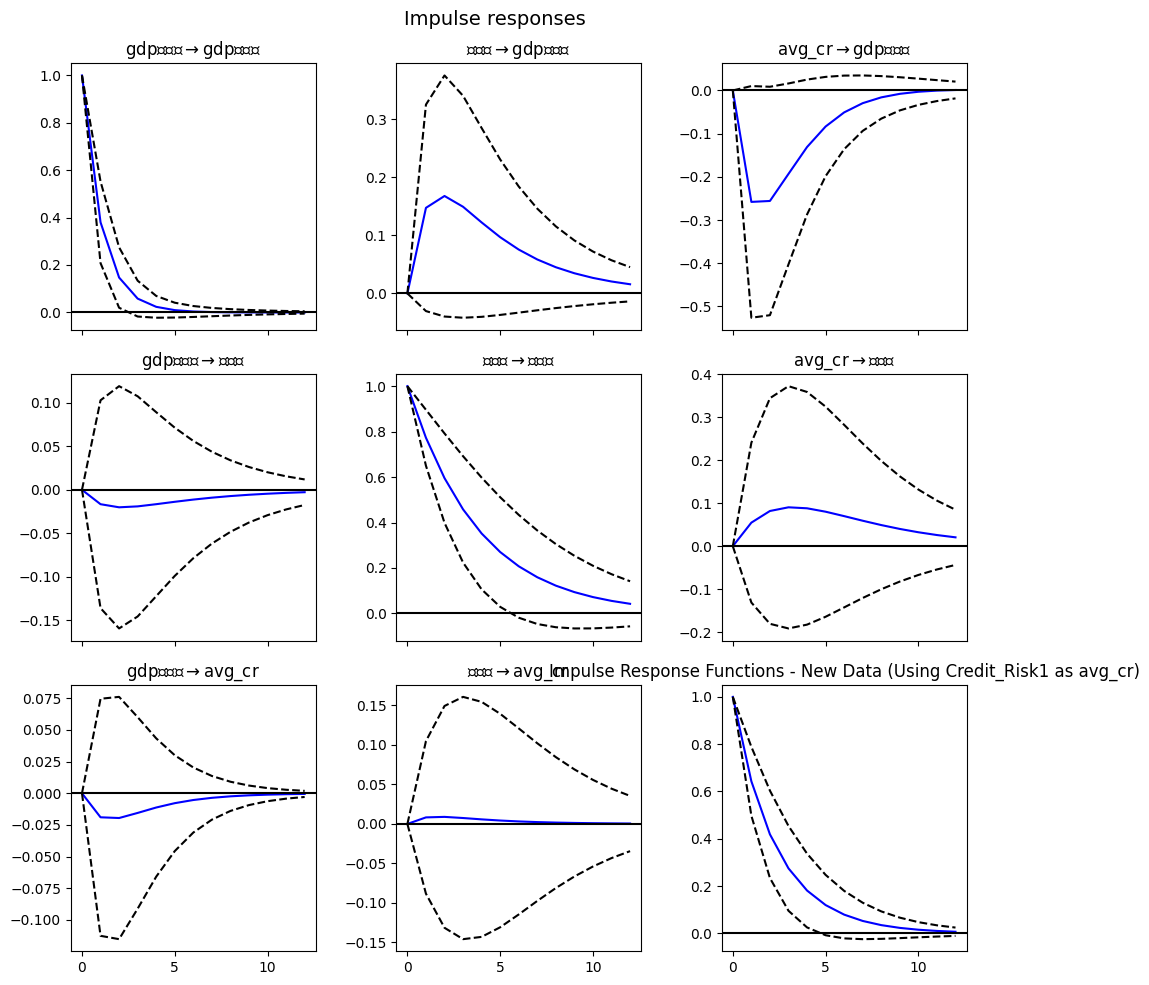

In [4]:
# 주어진 엑셀 파일들로부터 데이터를 로드
new_files = [
    '/content/인도_서비스_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr.xlsx',
    '/content/인도_소매_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr.xlsx',
    '/content/인도_에너지_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr.xlsx',
    '/content/인도_제조_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr.xlsx',

]

# 데이터프레임을 저장할 빈 리스트를 초기화
new_dfs = []

# 각 파일을 데이터프레임으로 로드하고 리스트에 추가
for file in new_files:
    df = pd.read_excel(file)
    new_dfs.append(df)

new_combined_df = pd.DataFrame()

for df in new_dfs:
    temp_df = df[['gdp성장률', '실업률', 'avg_cr']]
    new_combined_df = pd.concat([new_combined_df, temp_df], ignore_index=True)

new_combined_df['avg_cr_diff'] = new_combined_df['avg_cr'].diff().dropna()

# 새로운 결합된 데이터로 VAR 모델을 피팅
new_model = VAR(new_combined_df)
new_fitted_model = new_model.fit()

# 새로운 피팅된 모델로부터 충격반응 함수(IRFs)를 도출
new_irf = new_fitted_model.irf(12)  # 12 기간 예측

plt.figure(figsize=(10, 6))
new_irf.plot(orth=False)
plt.title('Impulse Response Functions - New Data (Using Credit_Risk1 as avg_cr)')
plt.tight_layout()
plt.show()

#상관계수행렬

In [21]:
country = '일본'
us_service = pd.read_excel("/content/일본_서비스_credit_risk(filtered).xlsx")
us_retail = pd.read_excel("/content/일본_소매_credit_risk(filtered).xlsx")
us_energy = pd.read_excel("/content/일본_에너지_credit_risk(filtered).xlsx")
us_manu = pd.read_excel("/content/일본_제조_credit_risk(filtered).xlsx")

In [22]:
us_service = us_service[['gdp성장률','실업률','Credit_Risk1','Credit_Risk2','Credit_Risk3','Credit_Risk4']]
us_service.corr()

,gdp성장률,실업률,Credit_Risk1,Credit_Risk2,Credit_Risk3,Credit_Risk4
gdp성장률,1.000000,0.121906,-0.355147,0.048778,0.101059,0.344673
실업률,0.121906,1.000000,0.233346,0.438761,-0.147323,0.503722
Credit_Risk1,-0.355147,0.233346,1.000000,0.002435,-0.056803,-0.120325
Credit_Risk2,0.048778,0.438761,0.002435,1.000000,-0.119665,0.218712
Credit_Risk3,0.101059,-0.147323,-0.056803,-0.119665,1.000000,-0.252824
Credit_Risk4,0.344673,0.503722,-0.120325,0.218712,-0.252824,1.000000


In [23]:
us_retail = us_retail[['gdp성장률','실업률','Credit_Risk1','Credit_Risk2','Credit_Risk3','Credit_Risk4']]
us_retail.corr()

,gdp성장률,실업률,Credit_Risk1,Credit_Risk2,Credit_Risk3,Credit_Risk4
gdp성장률,1.000000,0.150004,-0.015420,-0.098708,0.018746,-0.045003
실업률,0.150004,1.000000,0.504206,0.444201,0.092589,-0.136615
Credit_Risk1,-0.015420,0.504206,1.000000,0.820111,-0.136490,0.688624
Credit_Risk2,-0.098708,0.444201,0.820111,1.000000,0.050887,0.567455
Credit_Risk3,0.018746,0.092589,-0.136490,0.050887,1.000000,-0.081471
Credit_Risk4,-0.045003,-0.136615,0.688624,0.567455,-0.081471,1.000000


In [24]:
us_energy = us_energy[['gdp성장률','실업률','Credit_Risk1','Credit_Risk2','Credit_Risk3','Credit_Risk4']]
us_energy.corr()

,gdp성장률,실업률,Credit_Risk1,Credit_Risk2,Credit_Risk3,Credit_Risk4
gdp성장률,1.000000,0.150004,-0.070490,0.187549,-0.155628,-0.525457
실업률,0.150004,1.000000,-0.167849,0.422427,-0.802947,0.034078
Credit_Risk1,-0.070490,-0.167849,1.000000,-0.038038,0.632213,0.360015
Credit_Risk2,0.187549,0.422427,-0.038038,1.000000,-0.369603,-0.007970
Credit_Risk3,-0.155628,-0.802947,0.632213,-0.369603,1.000000,0.216735
Credit_Risk4,-0.525457,0.034078,0.360015,-0.007970,0.216735,1.000000


In [25]:
us_manu = us_manu[['gdp성장률','실업률','Credit_Risk1','Credit_Risk2','Credit_Risk3','Credit_Risk4']]
us_manu.corr()

,gdp성장률,실업률,Credit_Risk1,Credit_Risk2,Credit_Risk3,Credit_Risk4
gdp성장률,1.000000,0.150004,-0.085981,0.152389,-0.046678,0.085955
실업률,0.150004,1.000000,0.740342,0.362154,-0.269256,0.445964
Credit_Risk1,-0.085981,0.740342,1.000000,0.079636,-0.498511,0.520409
Credit_Risk2,0.152389,0.362154,0.079636,1.000000,0.586991,-0.262585
Credit_Risk3,-0.046678,-0.269256,-0.498511,0.586991,1.000000,-0.754966
Credit_Risk4,0.085955,0.445964,0.520409,-0.262585,-0.754966,1.000000


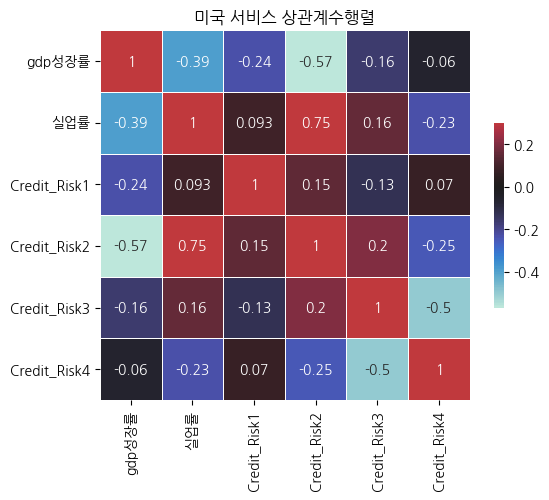

In [14]:
sns.heatmap(us_service.corr(), vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title('미국 서비스 상관계수행렬')
plt.show()

#ploting이미지 다운

In [55]:
# Function to plot data and save as an image
def plot_and_save_image(file_path):
    df = pd.read_excel(file_path)

    # Create a new DataFrame with only the required columns
    new_df = df[['기간', '실업률', 'gdp성장률', 'avg_cr']]

    # Plotting
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(new_df['기간'], new_df['avg_cr'], label='avg_cr', color='blue')
    ax1.plot(new_df['기간'], new_df['실업률'], label='실업률', linestyle='--', color='green')
    ax1.plot(new_df['기간'], new_df['gdp성장률'], label='gdp성장률', linestyle='--', color='red')

    ax1.set_ylabel('', color='blue')
    ax1.set_xlabel('기간')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    # Set chart title based on the file name
    title = file_path.split('/')[-1].replace('_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr.xlsx', '').replace('_', ' ') + ' Credit Risk vs GDP 성장률 및 실업률'
    plt.title(title)

    fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

    # Save the plot as an image file
    output_image_path = file_path.replace('.xlsx', '_plot.png')
    plt.savefig(output_image_path)
    plt.close()

    return output_image_path

# List of file paths to process
new_output_paths = [
  '/content/미국_서비스_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr.xlsx',
  '/content/미국_소매_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr.xlsx',
  '/content/미국_에너지_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr.xlsx',
  '/content/미국_제조_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr.xlsx',
  '/content/인도_서비스_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr.xlsx',
  '/content/인도_소매_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr.xlsx',
  '/content/인도_에너지_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr.xlsx',
  '/content/인도_제조_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr.xlsx',

]

# Process each new file to plot and save as image
image_output_paths = [plot_and_save_image(file_path) for file_path in new_output_paths]

image_output_paths


['/content/미국_서비스_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr_plot.png',
 '/content/미국_소매_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr_plot.png',
 '/content/미국_에너지_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr_plot.png',
 '/content/미국_제조_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr_plot.png',
 '/content/인도_서비스_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr_plot.png',
 '/content/인도_소매_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr_plot.png',
 '/content/인도_에너지_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr_plot.png',
 '/content/인도_제조_Credit_Risk_Extended_Standardized_Adjusted_with_avg_cr_plot.png']

# 신버전

In [50]:
####################################부도율 데이터프레임 만들기
file_path = '/content/미국_제조.xlsx'
df_ = pd.read_excel(file_path)

r = 0.041
T = df_.shape[0]

def calculate_default_probability(V, D, sigma, r, T):
    d2 = (np.log(V) - np.log(D) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(-d2)

df_ = df_.replace(0, np.nan)

df = df_.dropna(subset=['영업이익1','부채1','시가총액1','영업이익2','부채2','시가총액2','영업이익3','부채3','시가총액3','영업이익4','부채4','시가총액4','gdp성장률', '실업률'])

# Assuming sigma is calculated as the standard deviation of asset returns (simplified)
# For real applications, sigma should be based on historical volatility of the firm's asset value
cap_volatility = df[['시가총액1', '시가총액2', '시가총액3', '시가총액4']].pct_change().std().mean()

# Calculate default probabilities only where both market cap and debt values are present
for i in range(1, 5):
    df[f'부도율{i}'] = calculate_default_probability(df[f'시가총액{i}'], df[f'부채{i}'], cap_volatility, r, T)

df_cleaned = df.dropna(subset=['gdp성장률', '실업률', '부도율1', '부도율2', '부도율3', '부도율4'])

In [51]:
####################################데이터 정규화
# Normalize the data
scaler = StandardScaler()
df_cleaned[['gdp성장률', '실업률']] = scaler.fit_transform(df_cleaned[['gdp성장률', '실업률']])
for i in range(1, 5):
    df_cleaned[f'부도율{i}'] = scaler.fit_transform(df_cleaned[[f'부도율{i}']])

df_var = df_cleaned[['gdp성장률', '실업률', '부도율1', '부도율2', '부도율3', '부도율4']]

In [ ]:
####################################데이터 정규화 및 시각화
# Define a function to standardize data and adjust to start from 0
def standardize_and_adjust_data(df):
    scaler = StandardScaler()
    data_to_standardize = df.drop(columns=['기간'])
    standardized_data = pd.DataFrame(scaler.fit_transform(data_to_standardize), columns=data_to_standardize.columns)
    standardized_data = standardized_data - standardized_data.iloc[0]
    standardized_data['기간'] = df['기간']
    return standardized_data

# File paths
file_paths = [
    "미국_서비스_cleaned_default_probabilities파일의 path",
    "",
    "",
    "",
]

# Standardize and adjust data for each file and save
adjusted_standardized_data_files = {}
for file_path in file_paths:
    data = pd.read_excel(file_path, sheet_name='Sheet1')
    adjusted_standardized_data = standardize_and_adjust_data(data)
    adjusted_standardized_file_path = file_path.replace('.xlsx', '_adjusted_standardized.xlsx')
    adjusted_standardized_data.to_excel(adjusted_standardized_file_path, index=False)
    adjusted_standardized_data_files[file_path] = adjusted_standardized_file_path

# Plot adjusted standardized data
for file_path, adjusted_standardized_file_path in adjusted_standardized_data_files.items():
    adjusted_standardized_data = pd.read_excel(adjusted_standardized_file_path)

    plt.figure(figsize=(14, 8))
    for column in adjusted_standardized_data.columns:
        if column != '기간':
            plt.plot(adjusted_standardized_data['기간'], adjusted_standardized_data[column], label=column)

    plt.title(f'{file_path.split("/")[-1].replace("_cleaned_default_probabilities.xlsx", "")} - Adjusted Standardized Data')
    plt.xlabel('기간')
    plt.ylabel('Adjusted Standardized Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Display download links for the adjusted standardized files
adjusted_standardized_data_files

           기간       영업이익1        부채1        시가총액1       영업이익2          부채2  \
4  2014-03-01  -27.295800   869.5274  2652.977704 -198.690881   717.179627   
5  2014-06-01   85.825600   862.6016  2383.740716 -362.848094  1074.415243   
6  2014-09-01 -669.901400  1727.1044  2649.209757 -158.820001  1183.661590   
7  2014-12-01 -643.556200   693.8022  2223.089129 -948.203673  1040.628067   
8  2015-03-01  570.088400   675.6050  2360.105408 -165.072776  1182.394711   
9  2015-06-01  127.787800   751.9246  2277.895640 -203.823171  1208.818947   
10 2015-09-01  153.182400   768.6280  2469.718431 -156.423674  1644.278079   
11 2015-12-01  913.662400   681.5802  2860.214827 -946.058441  2101.584443   
12 2016-03-01   50.110200   619.2480  2538.226571 -136.128908  1770.513685   
13 2016-06-01  194.737200   630.1120  3377.108740  -99.367848  1297.082293   
14 2016-09-01   75.640600   630.1120  3848.102199  -82.121927  2276.113381   
15 2016-12-01   -0.543200   834.0836  3449.384827 -487.483161  1

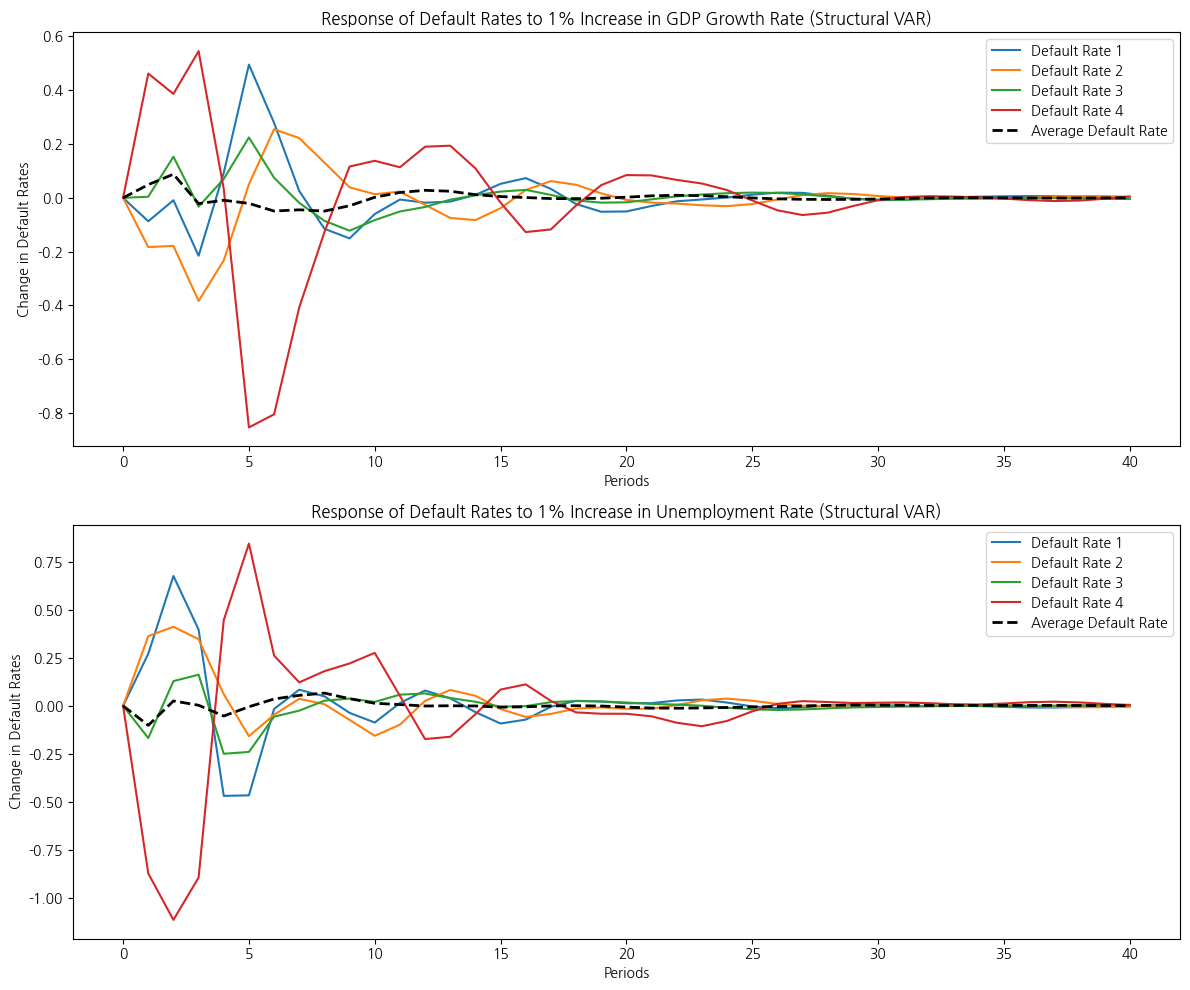

In [49]:
# Fit the VAR model
model = VAR(df_var)
results = model.fit(maxlags=3, ic='aic')

# Calculate the impulse response for 40 or max lenght of df_var periods
irf = results.irf(df_var.shape[0])

# Get the impulse response values
irf_gdp_to_default1 = irf.orth_irfs[:, 0, 2]
irf_gdp_to_default2 = irf.orth_irfs[:, 0, 3]
irf_gdp_to_default3 = irf.orth_irfs[:, 0, 4]
irf_gdp_to_default4 = irf.orth_irfs[:, 0, 5]

irf_unemployment_to_default1 = irf.orth_irfs[:, 1, 2]
irf_unemployment_to_default2 = irf.orth_irfs[:, 1, 3]
irf_unemployment_to_default3 = irf.orth_irfs[:, 1, 4]
irf_unemployment_to_default4 = irf.orth_irfs[:, 1, 5]
####################################구조적 VAR 및 충격반응함수 결과

# Calculate the average impulse response for the default rates
irf_gdp_to_default_avg = (irf_gdp_to_default1 + irf_gdp_to_default2 + irf_gdp_to_default3 + irf_gdp_to_default4) / 4
irf_unemployment_to_default_avg = (irf_unemployment_to_default1 + irf_unemployment_to_default2 + irf_unemployment_to_default3 + irf_unemployment_to_default4) / 4

periods = range(41)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot GDP to default rates
axes[0].plot(periods, irf_gdp_to_default1, label='Default Rate 1')
axes[0].plot(periods, irf_gdp_to_default2, label='Default Rate 2')
axes[0].plot(periods, irf_gdp_to_default3, label='Default Rate 3')
axes[0].plot(periods, irf_gdp_to_default4, label='Default Rate 4')
axes[0].plot(periods, irf_gdp_to_default_avg, label='Average Default Rate', linestyle='--', linewidth=2, color='black')
axes[0].set_title('Response of Default Rates to 1% Increase in GDP Growth Rate (Structural VAR)')
axes[0].set_xlabel('Periods')
axes[0].set_ylabel('Change in Default Rates')
axes[0].legend()

# Plot Unemployment to default rates
axes[1].plot(periods, irf_unemployment_to_default1, label='Default Rate 1')
axes[1].plot(periods, irf_unemployment_to_default2, label='Default Rate 2')
axes[1].plot(periods, irf_unemployment_to_default3, label='Default Rate 3')
axes[1].plot(periods, irf_unemployment_to_default4, label='Default Rate 4')
axes[1].plot(periods, irf_unemployment_to_default_avg, label='Average Default Rate', linestyle='--', linewidth=2, color='black')
axes[1].set_title('Response of Default Rates to 1% Increase in Unemployment Rate (Structural VAR)')
axes[1].set_xlabel('Periods')
axes[1].set_ylabel('Change in Default Rates')
axes[1].legend()

plt.tight_layout()
plt.show()


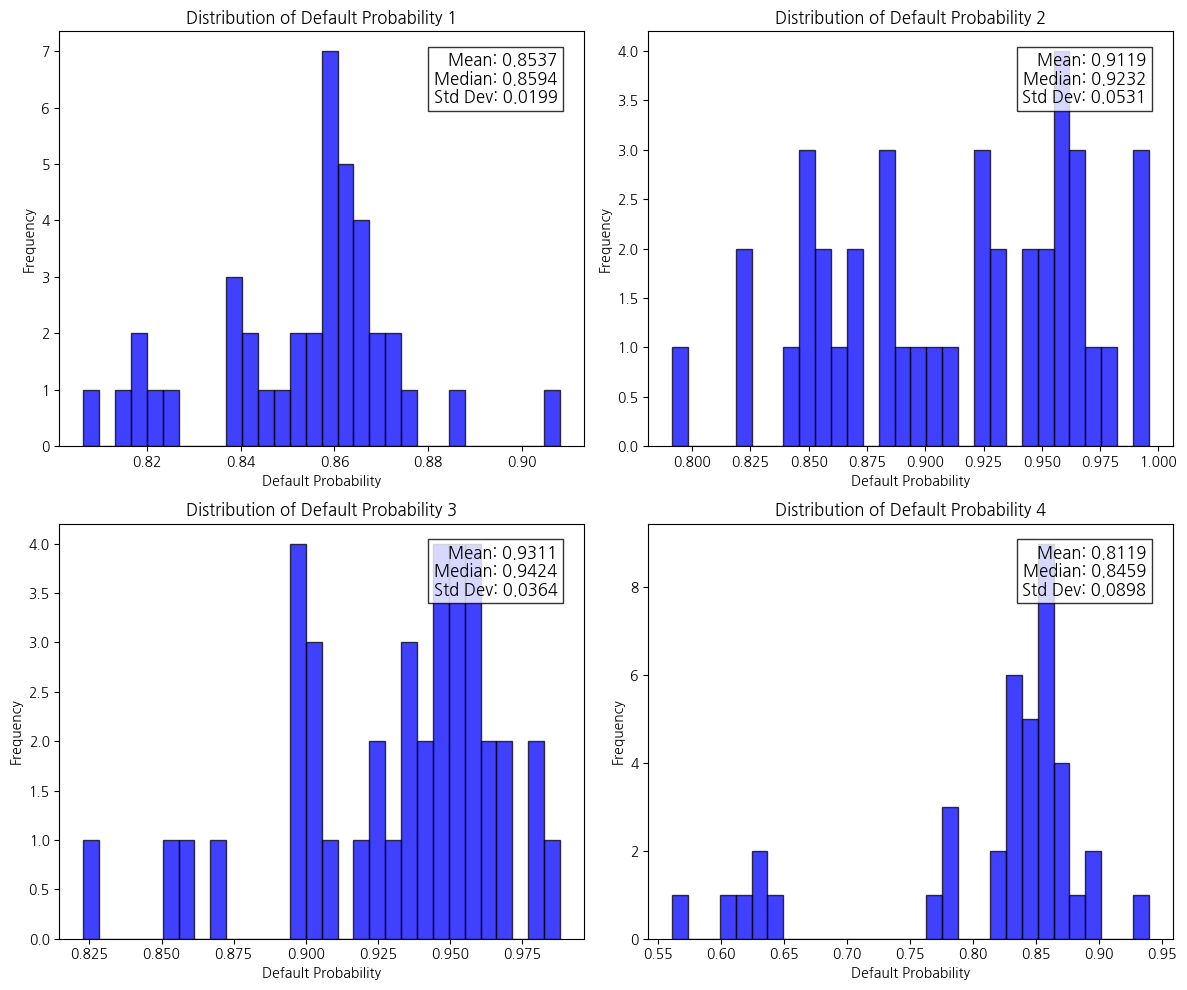

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.flatten(), 1):
    data = df[f'부도율{i}'].dropna()
    ax.hist(data, bins=30, alpha=0.75, color='blue', edgecolor='black')
    ax.set_title(f'Distribution of Default Probability {i}')
    ax.set_xlabel('Default Probability')
    ax.set_ylabel('Frequency')

    # Calculate basic statistics
    mean = np.mean(data)
    median = np.median(data)
    std_dev = np.std(data)

    # Annotate statistics on the plot
    textstr = '\n'.join((
        f'Mean: {mean:.4f}',
        f'Median: {median:.4f}',
        f'Std Dev: {std_dev:.4f}'
    ))
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [23]:
irf_unemployment_df = pd.DataFrame(
    data = {
    '부도율1':irf_unemployment_to_default1,
    '부도율2':irf_unemployment_to_default2,
    '부도율3':irf_unemployment_to_default3,
    '부도율4':irf_unemployment_to_default4,
    '평균부도율-실업률':irf_unemployment_to_default_avg
    }
)
irf_unemployment_df

,부도율1,부도율2,부도율3,부도율4,평균부도율-gdp,평균부도율-실업률
0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
1,6.833540e-02,0.093686,-4.167317e-01,-6.877268e-02,6.573361e-02,-0.080871
2,1.385784e-01,0.069797,-3.044378e-01,7.440230e-03,7.404516e-02,-0.022155
3,1.325255e-01,0.042982,-1.377724e-01,5.856157e-02,9.874049e-03,0.024074
4,8.877018e-02,0.037441,-4.826354e-02,6.284079e-02,-3.289123e-02,0.035197
5,5.155777e-02,0.040942,-2.435938e-02,4.580604e-02,-3.569353e-02,0.028487
6,3.312181e-02,0.041341,-2.219870e-02,2.954375e-02,-2.144328e-02,0.020452
7,2.603918e-02,0.036453,-1.802137e-02,2.021224e-02,-9.795263e-03,0.016171
8,2.164632e-02,0.029346,-9.747058e-03,1.524663e-02,-5.264253e-03,0.014123
9,1.676014e-02,0.022817,-2.203431e-03,1.150462e-02,-4.475190e-03,0.012220


In [24]:
irf_gdp_df = pd.DataFrame(
    data = {
    '부도율1':irf_gdp_to_default1,
    '부도율2':irf_gdp_to_default2,
    '부도율3':irf_gdp_to_default3,
    '부도율4':irf_gdp_to_default4,
    '평균부도율-gdp':irf_gdp_to_default_avg,
    }
)
irf_gdp_df

,부도율1,부도율2,부도율3,부도율4,평균부도율-gdp
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,2.005660e-01,-1.793685e-01,1.146725e-01,1.270645e-01,6.573361e-02
2,4.462875e-02,-1.795038e-01,3.027186e-01,1.283370e-01,7.404516e-02
3,-8.248464e-02,-9.844815e-02,1.844423e-01,3.598666e-02,9.874049e-03
4,-9.323030e-02,-4.043975e-02,2.560014e-02,-2.349501e-02,-3.289123e-02
5,-5.040077e-02,-2.324331e-02,-4.022109e-02,-2.890893e-02,-3.569353e-02
6,-1.526589e-02,-2.403351e-02,-3.423935e-02,-1.223436e-02,-2.144328e-02
7,-3.070524e-03,-2.403953e-02,-1.265137e-02,5.803690e-04,-9.795263e-03
8,-3.290404e-03,-1.925837e-02,-2.579925e-03,4.071684e-03,-5.264253e-03
9,-4.760256e-03,-1.294927e-02,-3.167896e-03,2.976663e-03,-4.475190e-03


In [26]:
# gdp가 1퍼센트 상승했을 때 부도율의 변화(%)
gdp_to_default_std_lst = []
for i in range(1,5):
    data = df[f'부도율{i}'].dropna()

    # Calculate basic statistics
    # mean = np.mean(data)
    # median = np.median(data)
    std_dev = np.std(data)

    gdp_to_default_std_lst.append(std_dev)

irf_gdp_to_default_avg_std = np.std(irf_gdp_to_default_avg)
irf_gdp_percent_df = pd.DataFrame(
    data = {
    '부도율1':irf_gdp_to_default1*gdp_to_default_std_lst[0],
    '부도율2':irf_gdp_to_default2*gdp_to_default_std_lst[1],
    '부도율3':irf_gdp_to_default3*gdp_to_default_std_lst[2],
    '부도율4':irf_gdp_to_default4*gdp_to_default_std_lst[3],
    '평균부도율-gdp':irf_gdp_to_default_avg*irf_gdp_to_default_avg_std,
    }
)
irf_gdp_percent_df

,부도율1,부도율2,부도율3,부도율4,평균부도율-gdp
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,3.998857e-03,-9.517958e-03,4.177372e-03,1.140779e-02,1.164510e-03
2,8.898019e-04,-9.525136e-03,1.102765e-02,1.152204e-02,1.311754e-03
3,-1.644568e-03,-5.224024e-03,6.718998e-03,3.230866e-03,1.749246e-04
4,-1.858813e-03,-2.145883e-03,9.325802e-04,-2.109371e-03,-5.826876e-04
5,-1.004884e-03,-1.233376e-03,-1.465203e-03,-2.595431e-03,-6.323319e-04
6,-3.043692e-04,-1.275307e-03,-1.247296e-03,-1.098395e-03,-3.798803e-04
7,-6.121968e-05,-1.275627e-03,-4.608731e-04,5.210526e-05,-1.735289e-04
8,-6.560363e-05,-1.021920e-03,-9.398335e-05,3.655539e-04,-9.325935e-05
9,-9.490933e-05,-6.871363e-04,-1.154024e-04,2.672435e-04,-7.928063e-05


<Axes: >

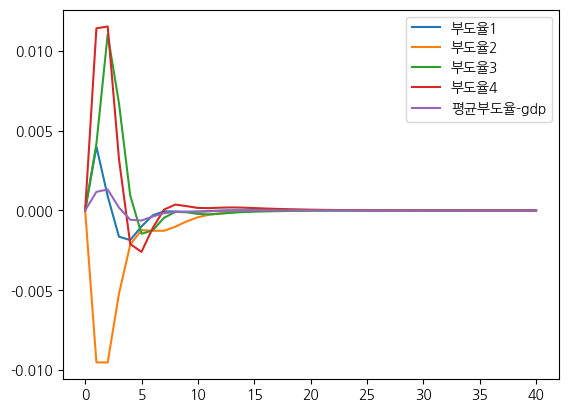

In [28]:
irf_gdp_percent_df.plot()

# 구버전

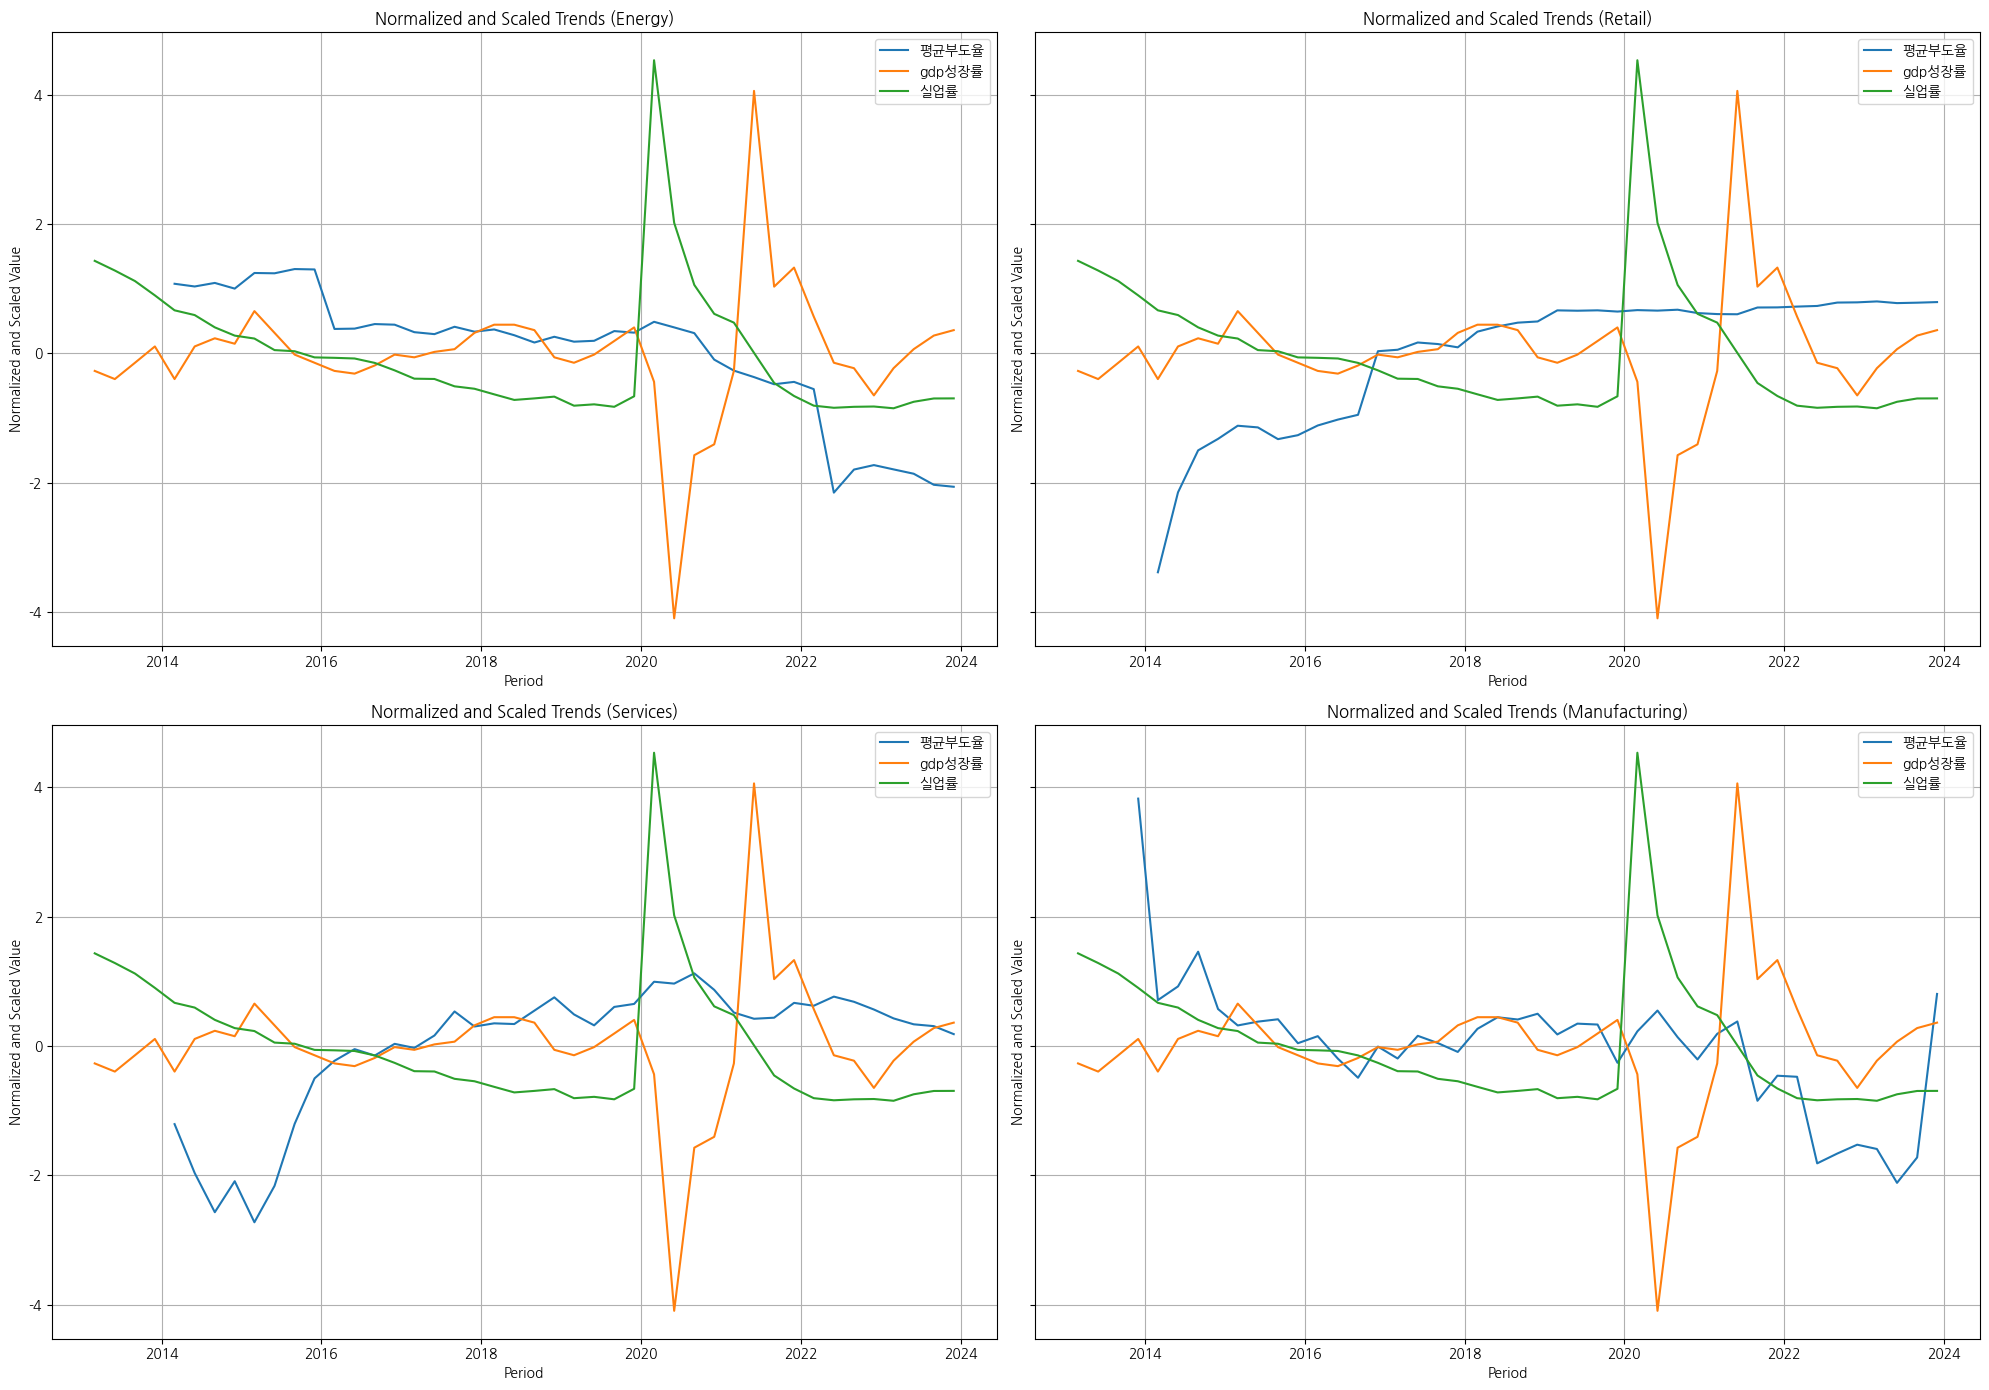

In [5]:
# Function to calculate default probabilities using the Merton model
def calculate_default_probability(V, D, r, sigma, T):
    if np.isnan(V) or np.isnan(D) or V <= 0 or D <= 0:
        return np.nan
    d1 = (np.log(V / D) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return 1 - stats.norm.cdf(d2)

# Function to calculate default probabilities for a given dataset using the Merton model
def calculate_default_probabilities(data):
    for i in range(1, 5):
        data[f'시가총액{i}'].replace(0, np.nan, inplace=True)
        data[f'부채{i}'].replace(0, np.nan, inplace=True)

    volatilities = [np.std(np.diff(np.log(data[f'시가총액{i}'].dropna()))) * np.sqrt(252) for i in range(1, 5)]

    for i in range(1, 5):
        sigma = volatilities[i-1]
        data[f'부도율{i}'] = data.apply(lambda row: calculate_default_probability(row[f'시가총액{i}'], row[f'부채{i}'], r, sigma, T), axis=1)

    return data

# Set parameters for the Merton model
r = 0.03  # Risk-free rate
T = 1     # Time to maturity in years

# Load all provided Excel files
file_paths = {
    "energy": '/content/미국_에너지.xlsx',
    "retail": '/content/미국_소매.xlsx',
    "services": '/content/미국_서비스.xlsx',
    "manufacturing": '/content/미국_제조.xlsx'
}

# Load and process data for each sector
data_energy = calculate_default_probabilities(pd.read_excel(file_paths['energy']))
data_retail = calculate_default_probabilities(pd.read_excel(file_paths['retail']))
data_services = calculate_default_probabilities(pd.read_excel(file_paths['services']))
data_manufacturing = calculate_default_probabilities(pd.read_excel(file_paths['manufacturing']))

# Calculate the mean default rate
data_energy['평균부도율'] = data_energy[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)
data_retail['평균부도율'] = data_retail[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)
data_services['평균부도율'] = data_services[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)
data_manufacturing['평균부도율'] = data_manufacturing[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)


# Function to normalize and plot data
def normalize_and_plot(data, title, ax):
    plot_columns = ['평균부도율', 'gdp성장률', '실업률']
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data[plot_columns])
    normalized_df = pd.DataFrame(normalized_data, columns=plot_columns)
    normalized_df['기간'] = pd.to_datetime(data['기간'])

    for column in plot_columns:
        ax.plot(normalized_df['기간'], normalized_df[column], label=column)
    ax.set_title(title)
    ax.set_xlabel('기간')
    # ax.set_ylabel('Normalized and Scaled Value')
    ax.legend()
    ax.grid(True)

# Plot the data for each sector
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 14), sharey=True)

normalize_and_plot(data_energy, '에너지 부문', axes[0, 0])
normalize_and_plot(data_retail, '소매 부문', axes[0, 1])
normalize_and_plot(data_services, '서비스 부문', axes[1, 0])
normalize_and_plot(data_manufacturing, '제조 부문', axes[1, 1])

plt.tight_layout()
plt.show()


In [7]:
print(data_energy[['평균부도율', 'gdp성장률', '실업률']].corr())
print(data_retail[['평균부도율', 'gdp성장률', '실업률']].corr().iloc[-1])
print(data_services[['평균부도율', 'gdp성장률', '실업률']].corr().iloc[-1])
print(data_manufacturing[['평균부도율', 'gdp성장률', '실업률']].corr().iloc[-1])

           평균부도율    gdp성장률       실업률
평균부도율   1.000000 -0.067176  0.374866
gdp성장률 -0.067176  1.000000 -0.368378
실업률     0.374866 -0.368378  1.000000
평균부도율    -0.200944
gdp성장률   -0.368378
실업률       1.000000
Name: 실업률, dtype: float64
평균부도율    -0.078363
gdp성장률   -0.368378
실업률       1.000000
Name: 실업률, dtype: float64
평균부도율     0.372679
gdp성장률   -0.368378
실업률       1.000000
Name: 실업률, dtype: float64


# 개별 데이터, 평균 그리기

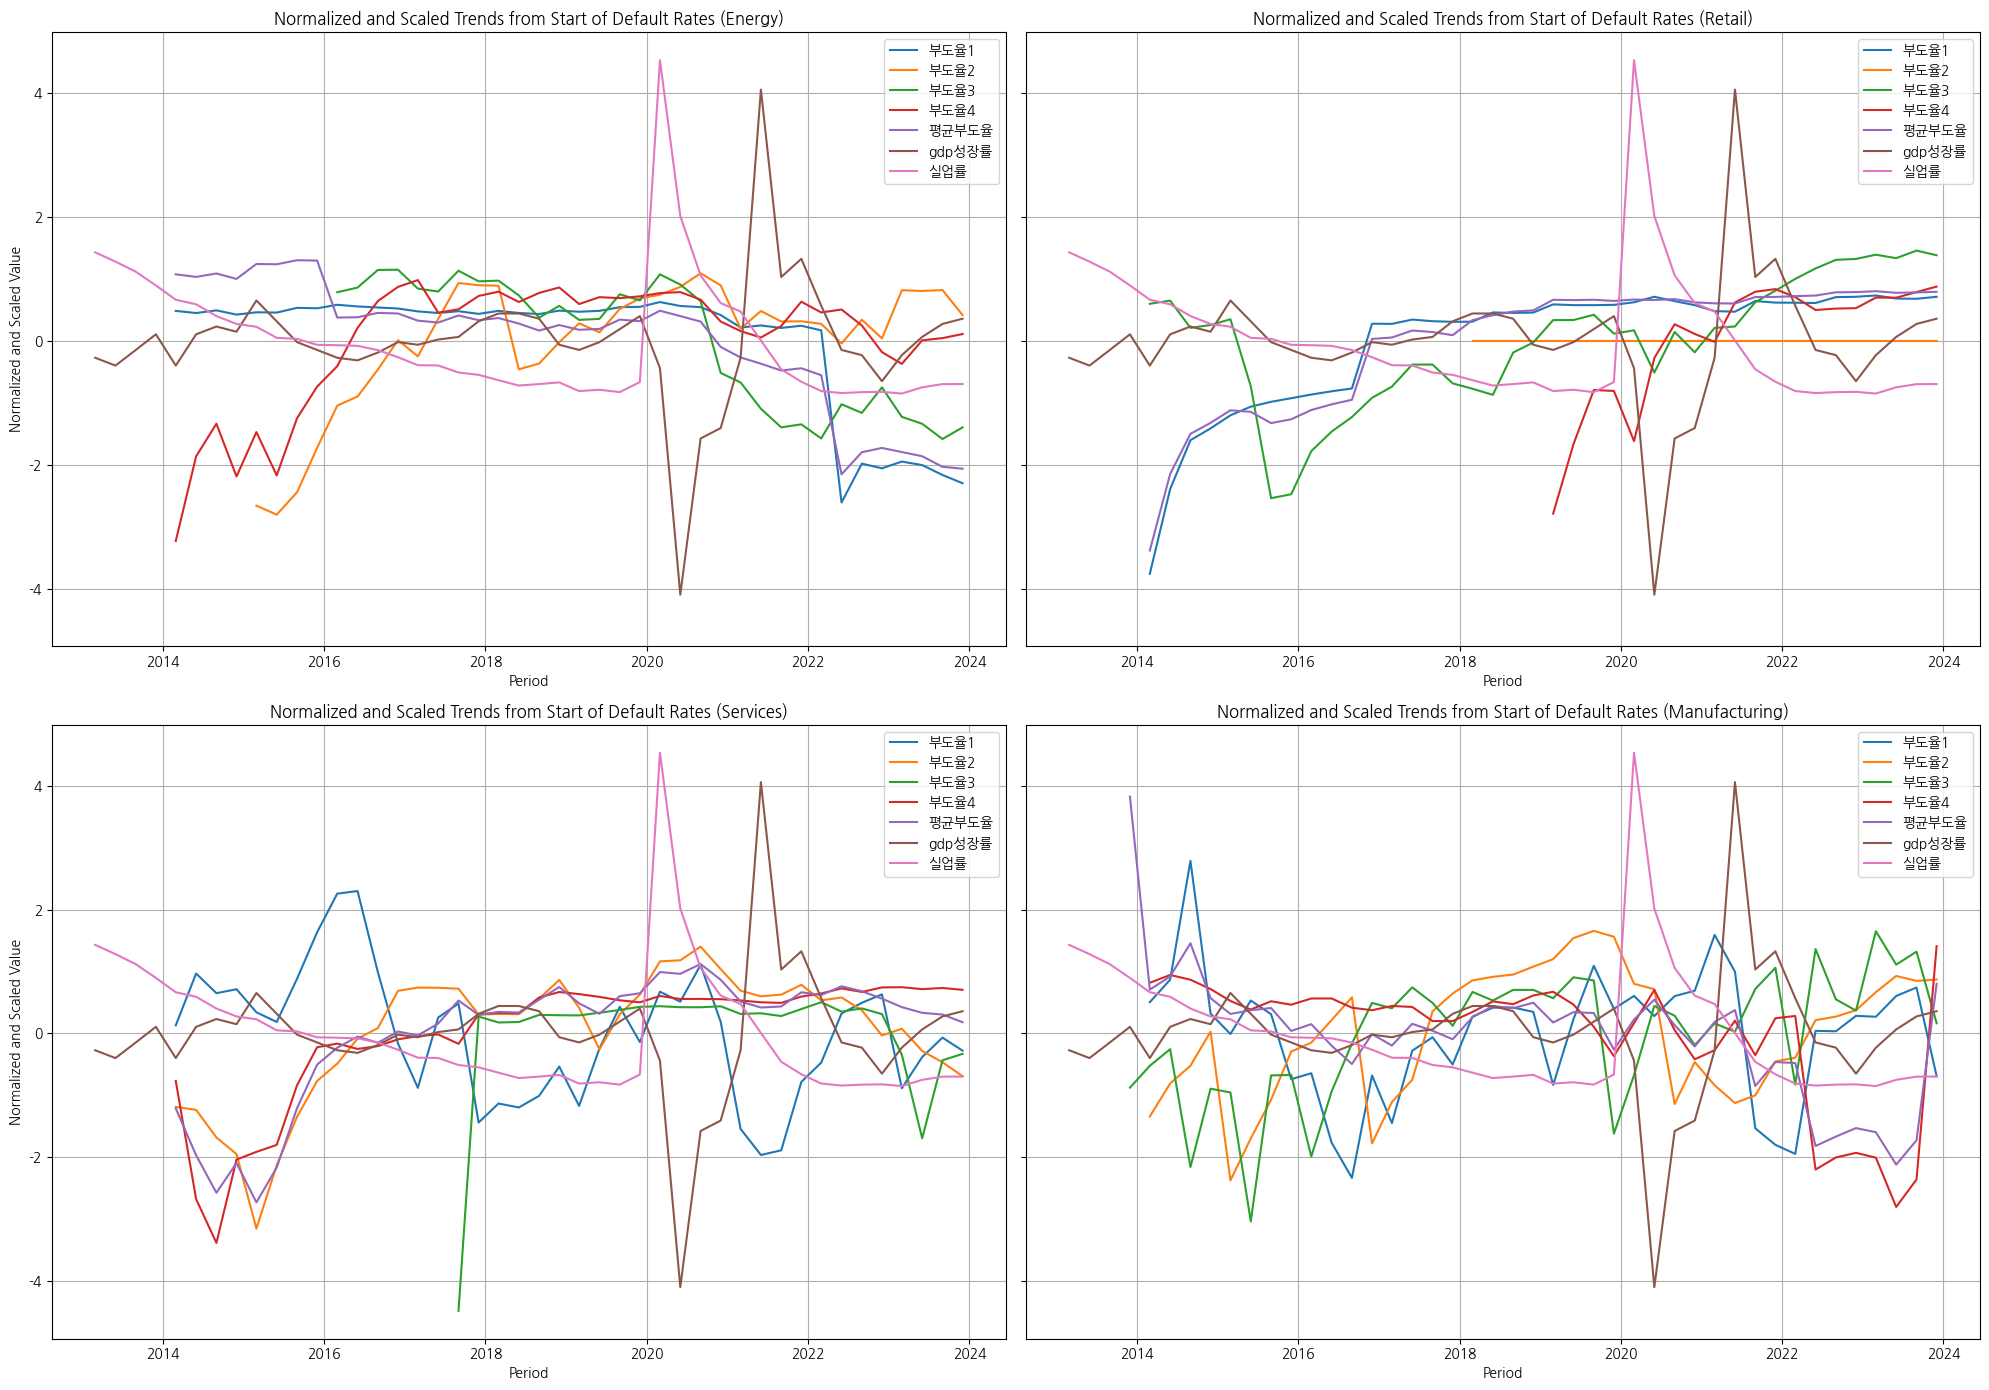

In [ ]:
# Function to calculate default probabilities using the Merton model
def calculate_default_probability(V, D, r, sigma, T):
    if np.isnan(V) or np.isnan(D) or V <= 0 or D <= 0:
        return np.nan
    d1 = (np.log(V / D) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return 1 - stats.norm.cdf(d2)

# Function to calculate default probabilities for a given dataset using the Merton model
def calculate_default_probabilities(data):
    # Replace 0 or negative values with NaN to avoid division by zero or invalid log operations
    for i in range(1, 5):
        data[f'시가총액{i}'].replace(0, np.nan, inplace=True)
        data[f'부채{i}'].replace(0, np.nan, inplace=True)

    # Calculate volatility (σ) as the standard deviation of the percentage changes in market cap
    volatilities = [np.std(np.diff(np.log(data[f'시가총액{i}'].dropna()))) * np.sqrt(252) for i in range(1, 5)]

    # Calculate default probabilities for each company using the Merton model
    for i in range(1, 5):
        sigma = volatilities[i-1]
        data[f'부도율{i}'] = data.apply(lambda row: calculate_default_probability(row[f'시가총액{i}'], row[f'부채{i}'], r, sigma, T), axis=1)

    return data

# Set the risk-free rate and time to maturity (assuming 1 year)
r = 0.03  # Example risk-free rate
T = 1  # Time to maturity in years

# Load all provided Excel files
file_paths = {
    "energy": '/content/미국_에너지.xlsx',
    "retail": '/content/미국_소매.xlsx',
    "services": '/content/미국_서비스.xlsx',
    "manufacturing": '/content/미국_제조.xlsx'
}

data_energy = pd.read_excel(file_paths['energy'])
data_retail = pd.read_excel(file_paths['retail'])
data_services = pd.read_excel(file_paths['services'])
data_manufacturing = pd.read_excel(file_paths['manufacturing'])

# Calculate default probabilities for all datasets using the Merton model
data_energy = calculate_default_probabilities(data_energy)
data_retail = calculate_default_probabilities(data_retail)
data_services = calculate_default_probabilities(data_services)
data_manufacturing = calculate_default_probabilities(data_manufacturing)

# Calculate the mean default rates
data_energy['평균부도율'] = data_energy[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)
data_retail['평균부도율'] = data_retail[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)
data_services['평균부도율'] = data_services[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)
data_manufacturing['평균부도율'] = data_manufacturing[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)

# Extract relevant columns for individual default probabilities plotting, including the mean default rates
plot_columns_individual = [f'부도율{i}' for i in range(1, 5)] + ['평균부도율', 'gdp성장률', '실업률']

# Normalize the data for all datasets
scaler = StandardScaler()
normalized_plot_data_energy_individual = scaler.fit_transform(data_energy[plot_columns_individual])
normalized_plot_data_retail_individual = scaler.fit_transform(data_retail[plot_columns_individual])
normalized_plot_data_services_individual = scaler.fit_transform(data_services[plot_columns_individual])
normalized_plot_data_manufacturing_individual = scaler.fit_transform(data_manufacturing[plot_columns_individual])

# Convert normalized data back to a DataFrame
normalized_plot_df_energy_individual = pd.DataFrame(normalized_plot_data_energy_individual, columns=plot_columns_individual)
normalized_plot_df_retail_individual = pd.DataFrame(normalized_plot_data_retail_individual, columns=plot_columns_individual)
normalized_plot_df_services_individual = pd.DataFrame(normalized_plot_data_services_individual, columns=plot_columns_individual)
normalized_plot_df_manufacturing_individual = pd.DataFrame(normalized_plot_data_manufacturing_individual, columns=plot_columns_individual)
normalized_plot_df_energy_individual['기간'] = data_energy['기간']
normalized_plot_df_retail_individual['기간'] = data_retail['기간']
normalized_plot_df_services_individual['기간'] = data_services['기간']
normalized_plot_df_manufacturing_individual['기간'] = data_manufacturing['기간']

# Convert '기간' to datetime for better x-axis labels for all datasets
normalized_plot_df_energy_individual['기간'] = pd.to_datetime(normalized_plot_df_energy_individual['기간'])
normalized_plot_df_retail_individual['기간'] = pd.to_datetime(normalized_plot_df_retail_individual['기간'])
normalized_plot_df_services_individual['기간'] = pd.to_datetime(normalized_plot_df_services_individual['기간'])
normalized_plot_df_manufacturing_individual['기간'] = pd.to_datetime(normalized_plot_df_manufacturing_individual['기간'])

# Plot the normalized and scaled data for all datasets
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 14), sharey=True)

# Plot for energy
for column in plot_columns_individual:
    axes[0, 0].plot(normalized_plot_df_energy_individual['기간'], normalized_plot_df_energy_individual[column], label=column)
axes[0, 0].set_title('Normalized and Scaled Trends from Start of Default Rates (Energy)')
axes[0, 0].set_xlabel('Period')
axes[0, 0].set_ylabel('Normalized and Scaled Value')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot for retail
for column in plot_columns_individual:
    axes[0, 1].plot(normalized_plot_df_retail_individual['기간'], normalized_plot_df_retail_individual[column], label=column)
axes[0, 1].set_title('Normalized and Scaled Trends from Start of Default Rates (Retail)')
axes[0, 1].set_xlabel('Period')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot for services
for column in plot_columns_individual:
    axes[1, 0].plot(normalized_plot_df_services_individual['기간'], normalized_plot_df_services_individual[column], label=column)
axes[1, 0].set_title('Normalized and Scaled Trends from Start of Default Rates (Services)')
axes[1, 0].set_xlabel('Period')
axes[1, 0].set_ylabel('Normalized and Scaled Value')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot for manufacturing
for column in plot_columns_individual:
    axes[1, 1].plot(normalized_plot_df_manufacturing_individual['기간'], normalized_plot_df_manufacturing_individual[column], label=column)
axes[1, 1].set_title('Normalized and Scaled Trends from Start of Default Rates (Manufacturing)')
axes[1, 1].set_xlabel('Period')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


# 구버전

        부도율1      부도율2      부도율3      부도율4    gdp성장률       실업률         기간
0        NaN       NaN       NaN       NaN  0.469072  0.423614 2013-03-01
1        NaN       NaN       NaN       NaN  0.453608  0.395783 2013-06-01
2        NaN       NaN       NaN       NaN  0.484536  0.365557 2013-09-01
3        NaN       NaN  0.460970       NaN  0.515464  0.324422 2013-12-01
4   0.554250  0.255977  0.536258  0.859674  0.453608  0.281459 2014-03-01
5   0.625200  0.388390  0.593446  0.889468  0.515464  0.267824 2014-06-01
6   1.000000  0.459412  0.187510  0.871344  0.530928  0.232529 2014-09-01
7   0.518348  0.596085  0.457327  0.835436  0.520619  0.208774 2014-12-01
8   0.453751  0.000000  0.444393  0.789889  0.582474  0.200388 2015-03-01
9   0.559423  0.167930  0.000000  0.757033  0.541237  0.167198 2015-06-01
10  0.516290  0.323294  0.503069  0.788675  0.500000  0.163899 2015-09-01
11  0.311410  0.516191  0.504781  0.775451  0.484536  0.146241 2015-12-01
12  0.330053  0.552221  0.223708  0.79

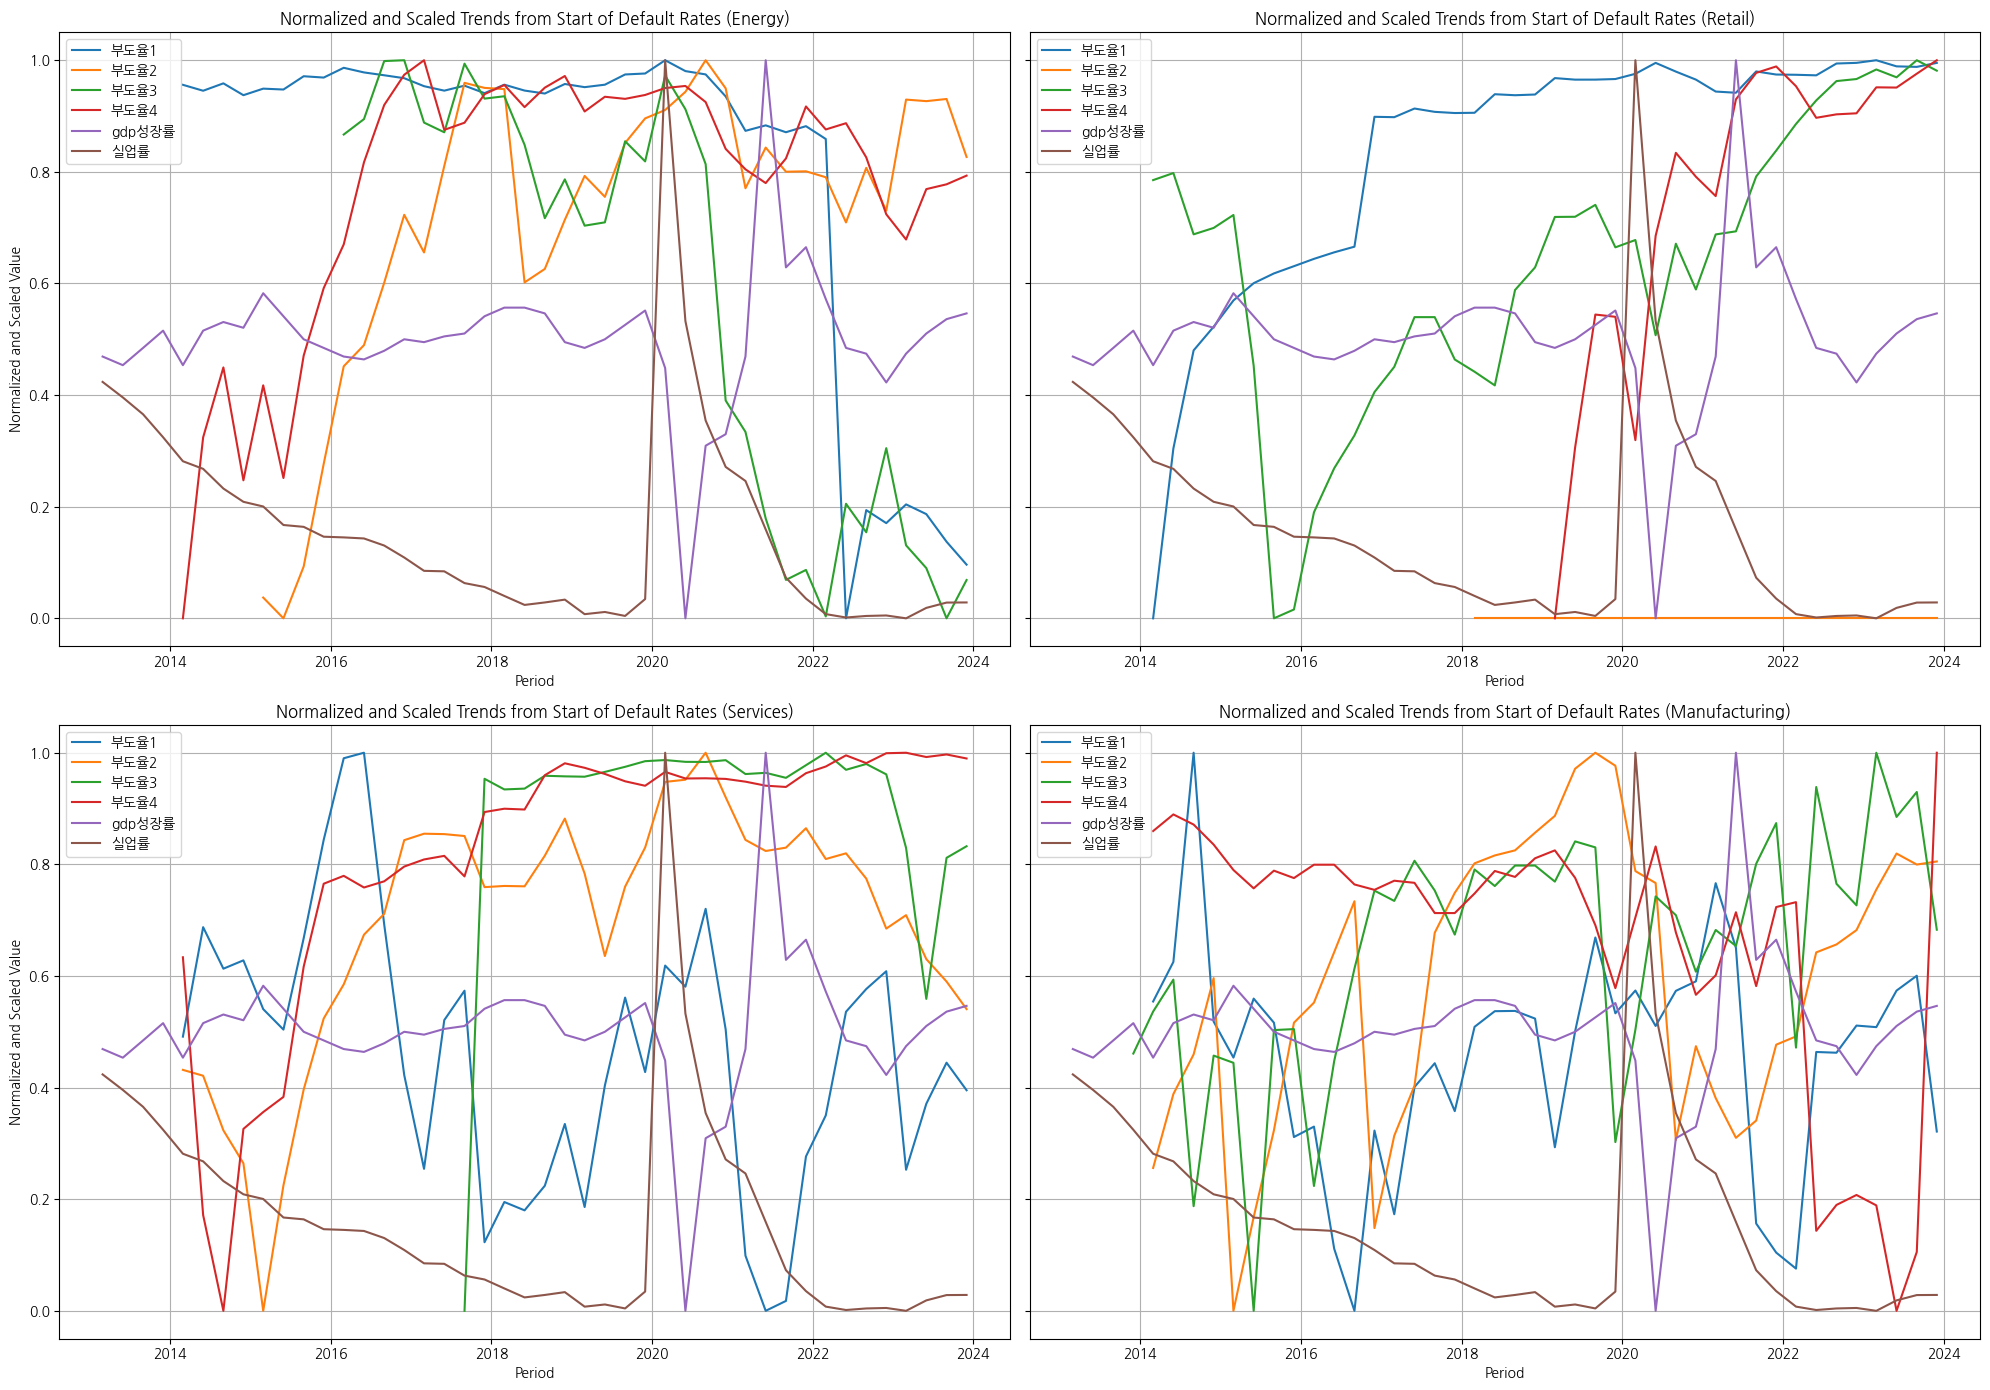

In [ ]:
# Function to calculate default probabilities using the Merton model
def calculate_default_probability(V, D, r, sigma, T):
    if np.isnan(V) or np.isnan(D) or V <= 0 or D <= 0:
        return np.nan
    d1 = (np.log(V / D) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return 1 - stats.norm.cdf(d2)

# Function to calculate default probabilities for a given dataset using the Merton model
def calculate_default_probabilities(data):
    # Replace 0 or negative values with NaN to avoid division by zero or invalid log operations
    for i in range(1, 5):
        data[f'시가총액{i}'].replace(0, np.nan, inplace=True)
        data[f'부채{i}'].replace(0, np.nan, inplace=True)

    # Calculate volatility (σ) as the standard deviation of the percentage changes in market cap
    volatilities = [np.std(np.diff(np.log(data[f'시가총액{i}'].dropna()))) * np.sqrt(252) for i in range(1, 5)]

    # Calculate default probabilities for each company using the Merton model
    for i in range(1, 5):
        sigma = volatilities[i-1]
        data[f'부도율{i}'] = data.apply(lambda row: calculate_default_probability(row[f'시가총액{i}'], row[f'부채{i}'], r, sigma, T), axis=1)

    return data

# Set the risk-free rate and time to maturity (assuming 1 year)
r = 0.03  # Example risk-free rate
T = 1  # Time to maturity in years

# Load all provided Excel files
file_paths = {
    "energy": '/content/미국_에너지.xlsx',
    "retail": '/content/미국_소매.xlsx',
    "services": '/content/미국_서비스.xlsx',
    "manufacturing": '/content/미국_제조.xlsx'
}

data_energy = pd.read_excel(file_paths['energy'])
data_retail = pd.read_excel(file_paths['retail'])
data_services = pd.read_excel(file_paths['services'])
data_manufacturing = pd.read_excel(file_paths['manufacturing'])

# Calculate default probabilities for all datasets using the Merton model
data_energy = calculate_default_probabilities(data_energy)
data_retail = calculate_default_probabilities(data_retail)
data_services = calculate_default_probabilities(data_services)
data_manufacturing = calculate_default_probabilities(data_manufacturing)

# Extract relevant columns for individual default probabilities plotting
plot_columns_individual = [f'부도율{i}' for i in range(1, 5)] + ['gdp성장률', '실업률']

# Normalize the data for all datasets
scaler = MinMaxScaler()
normalized_plot_data_energy_individual = scaler.fit_transform(data_energy[plot_columns_individual])
normalized_plot_data_retail_individual = scaler.fit_transform(data_retail[plot_columns_individual])
normalized_plot_data_services_individual = scaler.fit_transform(data_services[plot_columns_individual])
normalized_plot_data_manufacturing_individual = scaler.fit_transform(data_manufacturing[plot_columns_individual])

# Convert normalized data back to a DataFrame
normalized_plot_df_energy_individual = pd.DataFrame(normalized_plot_data_energy_individual, columns=plot_columns_individual)
normalized_plot_df_retail_individual = pd.DataFrame(normalized_plot_data_retail_individual, columns=plot_columns_individual)
normalized_plot_df_services_individual = pd.DataFrame(normalized_plot_data_services_individual, columns=plot_columns_individual)
normalized_plot_df_manufacturing_individual = pd.DataFrame(normalized_plot_data_manufacturing_individual, columns=plot_columns_individual)
normalized_plot_df_energy_individual['기간'] = data_energy['기간']
normalized_plot_df_retail_individual['기간'] = data_retail['기간']
normalized_plot_df_services_individual['기간'] = data_services['기간']
normalized_plot_df_manufacturing_individual['기간'] = data_manufacturing['기간']


# # Set the starting point to 0 by subtracting the first value of each column
# for column in plot_columns_individual:
#     normalized_plot_df_energy_individual[column] = normalized_plot_df_energy_individual[column] - normalized_plot_df_energy_individual[column].iloc[0]
#     normalized_plot_df_retail_individual[column] = normalized_plot_df_retail_individual[column] - normalized_plot_df_retail_individual[column].iloc[0]
#     normalized_plot_df_services_individual[column] = normalized_plot_df_services_individual[column] - normalized_plot_df_services_individual[column].iloc[0]
#     normalized_plot_df_manufacturing_individual[column] = normalized_plot_df_manufacturing_individual[column] - normalized_plot_df_manufacturing_individual[column].iloc[0]

# Convert '기간' to datetime for better x-axis labels for all datasets
normalized_plot_df_energy_individual['기간'] = pd.to_datetime(normalized_plot_df_energy_individual['기간'])
normalized_plot_df_retail_individual['기간'] = pd.to_datetime(normalized_plot_df_retail_individual['기간'])
normalized_plot_df_services_individual['기간'] = pd.to_datetime(normalized_plot_df_services_individual['기간'])
normalized_plot_df_manufacturing_individual['기간'] = pd.to_datetime(normalized_plot_df_manufacturing_individual['기간'])

# Plot the normalized and scaled data for all datasets
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 14), sharey=True)


# Plot for energy
for column in plot_columns_individual:
    axes[0, 0].plot(normalized_plot_df_energy_individual['기간'], normalized_plot_df_energy_individual[column], label=column)
axes[0, 0].set_title('Normalized and Scaled Trends from Start of Default Rates (Energy)')
axes[0, 0].set_xlabel('Period')
axes[0, 0].set_ylabel('Normalized and Scaled Value')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot for retail
for column in plot_columns_individual:
    axes[0, 1].plot(normalized_plot_df_retail_individual['기간'], normalized_plot_df_retail_individual[column], label=column)
axes[0, 1].set_title('Normalized and Scaled Trends from Start of Default Rates (Retail)')
axes[0, 1].set_xlabel('Period')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot for services
for column in plot_columns_individual:
    axes[1, 0].plot(normalized_plot_df_services_individual['기간'], normalized_plot_df_services_individual[column], label=column)
axes[1, 0].set_title('Normalized and Scaled Trends from Start of Default Rates (Services)')
axes[1, 0].set_xlabel('Period')
axes[1, 0].set_ylabel('Normalized and Scaled Value')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot for manufacturing
for column in plot_columns_individual:
    axes[1, 1].plot(normalized_plot_df_manufacturing_individual['기간'], normalized_plot_df_manufacturing_individual[column], label=column)
axes[1, 1].set_title('Normalized and Scaled Trends from Start of Default Rates (Manufacturing)')
axes[1, 1].set_xlabel('Period')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# 구버전

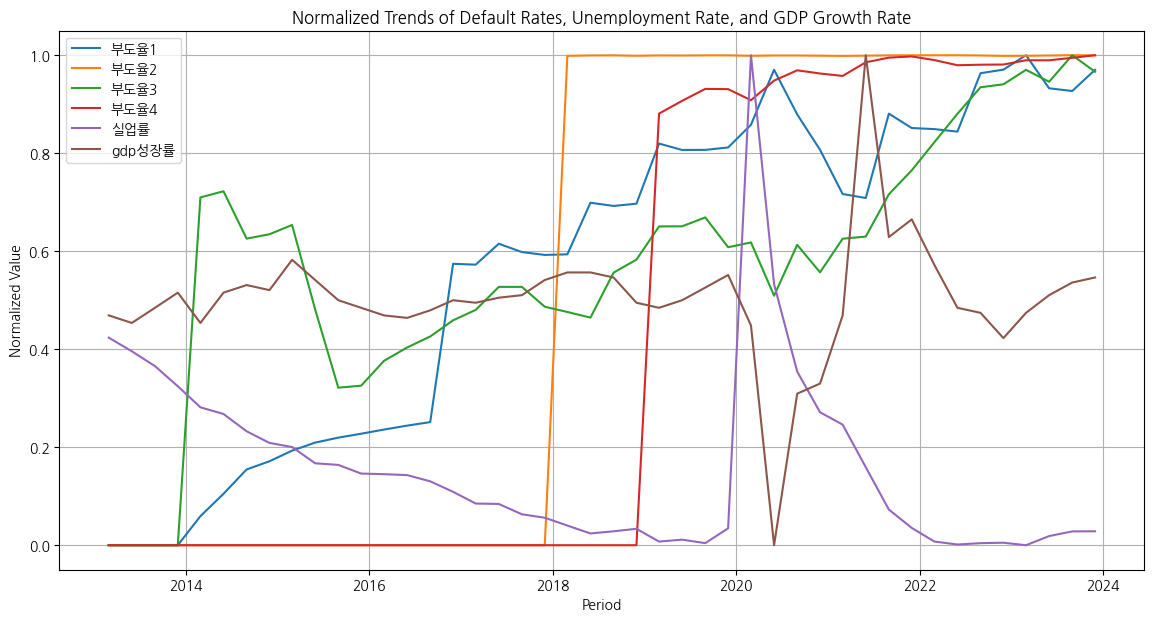

In [ ]:
data = pd.read_excel("/content/미국_소매.xlsx")
r=0.041
T=data.shape[0]
scaler = MinMaxScaler()
# Replace 0 or negative values with NaN to avoid division by zero or invalid log operations
data['시가총액1'].replace(0, np.nan, inplace=True)
data['시가총액2'].replace(0, np.nan, inplace=True)
data['시가총액3'].replace(0, np.nan, inplace=True)
data['시가총액4'].replace(0, np.nan, inplace=True)
data['부채1'].replace(0, np.nan, inplace=True)
data['부채2'].replace(0, np.nan, inplace=True)
data['부채3'].replace(0, np.nan, inplace=True)
data['부채4'].replace(0, np.nan, inplace=True)

# Calculate volatility (σ) as the standard deviation of the percentage changes in market cap
# This is a simple proxy and may not be accurate
sigma1 = np.std(np.diff(np.log(data['시가총액1'].dropna()))) # * np.sqrt(252)  # Annualized volatility
sigma2 = np.std(np.diff(np.log(data['시가총액2'].dropna()))) # * np.sqrt(252)
sigma3 = np.std(np.diff(np.log(data['시가총액3'].dropna()))) # * np.sqrt(252)
sigma4 = np.std(np.diff(np.log(data['시가총액4'].dropna()))) # * np.sqrt(252)

def calculate_default_probability(V, D, r, sigma, T):
    if np.isnan(V) or np.isnan(D) or V <= 0 or D <= 0:
        return np.nan
    d1 = (np.log(V / D) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return 1 - stats.norm.cdf(d2)

# Calculate default probabilities for each company
data['부도율1'] = data.apply(lambda row: calculate_default_probability(row['시가총액1'], row['부채1'], r, sigma1, T), axis=1)
data['부도율2'] = data.apply(lambda row: calculate_default_probability(row['시가총액2'], row['부채2'], r, sigma2, T), axis=1)
data['부도율3'] = data.apply(lambda row: calculate_default_probability(row['시가총액3'], row['부채3'], r, sigma3, T), axis=1)
data['부도율4'] = data.apply(lambda row: calculate_default_probability(row['시가총액4'], row['부채4'], r, sigma4, T), axis=1)

# Extract necessary columns for plotting
plot_columns = ['부도율1', '부도율2', '부도율3', '부도율4', '실업률', 'gdp성장률']

# Handle any NaN values before normalization
data.fillna(0, inplace=True)

# Normalize the data
normalized_plot_data = scaler.fit_transform(data[plot_columns])

# Convert normalized data back to a DataFrame
normalized_plot_df = pd.DataFrame(normalized_plot_data, columns=plot_columns)

# Plot the normalized data
plt.figure(figsize=(14, 7))
for column in normalized_plot_df.columns:
    plt.plot(data['기간'], normalized_plot_df[column], label=column)

plt.title('Normalized Trends of Default Rates, Unemployment Rate, and GDP Growth Rate')
plt.xlabel('Period')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.show()

# 구버전

In [ ]:
# 딕셔너리를 만들 때 필요한 리스트 변수를 만들고 반환하는 함수
def make_var_name_lst():
  var_name_lst = []
  # 각 기업 별로 나누기 위한 변수 만들기
  for i in range(1,5):
    tmp_lst = []
    date_name = '기간'
    profit_name = f'영업이익{i}'
    debt_name = f'부채{i}'
    market_name = f'시가총액{i}'
    tmp_lst.append(date_name)
    tmp_lst.append(profit_name)
    tmp_lst.append(debt_name)
    tmp_lst.append(market_name)
    var_name_lst.append(tmp_lst)
  return var_name_lst

In [ ]:
# 각 기업 별 데이터프레임을 만들기 위한 딕셔너리를 만들고 반환하는 함수
def make_dict(country_df, company_lst):

  var_name_lst = make_var_name_lst()

  # 각 기업 별로 데이터프레임 만들기 위한 딕셔너리 만들기
  data_dict = {}
  for company, var in zip(company_lst, var_name_lst):
    data_dict[company] = country_df[var]
  return data_dict

In [ ]:
# 각 기업 별 데이터프레임 만들기 위한 함수
def process_company_data(data_dict, company_key, var_name_lst_no_date, index):
  company = data_dict[company_key]
  company.index = company['기간']
  company = company.replace(0, np.nan)
  company = company.dropna()

  selected_vars = var_name_lst_no_date[index]
  company = company[selected_vars]
  company_profit_series = company[selected_vars[0]]
  company_debt_series = company[selected_vars[1]]
  company_market_series = company[selected_vars[2]]
  df_ = {
      '영업이익':company_profit_series,
      '부채':company_debt_series,
      '시가총액':company_market_series,
  }
  company_df = pd.DataFrame(df_, index=company.index)

  return company_df

In [ ]:
# 해당 산업 내 기업들의 credit risk를 계산해 하나의 데이터프레임으로 만드는 함수
def cal_credit_risk(r, data_dict, company_lst, var_name_lst_no_date):
  series_container = []
  for i in range(len(company_lst)):
    company_i = process_company_data(data_dict, company_lst[i], var_name_lst_no_date, i)
    company_i_profit_series = company_i['영업이익']
    company_i_debt_series = company_i['부채']
    company_i_market_series = company_i['시가총액']

    # recovery rate 계산
    recovery_rate_series_i = company_i_profit_series / company_i_debt_series
    recovery_rate_series_i = recovery_rate_series_i.clip(upper=1, lower=0)
    # 부도확률 계산
    STD_V = company_i_market_series.std()
    R = r
    T = company_i_market_series.shape[0]
    tmp = []
    for V, K in zip(company_i_market_series, company_i_debt_series):
      d1 = ((np.log(V)-np.log(K)) + (R + 0.5 * STD_V**2) * T) / (STD_V * np.sqrt(T))
      d2 = d1 - STD_V * np.sqrt(T)
      # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
      def_prob = norm.logcdf(d2)
      tmp.append(def_prob)
    company_i_default_rate_series = pd.Series(tmp, index=company_i.index)
    company_i_default_rate_series = (company_i_default_rate_series/company_i_default_rate_series.iloc[0])
    company_i_default_rate_series = company_i_default_rate_series.clip(upper=1, lower=0)
    # EAD 계산
    company_i_ead_series = company_i_debt_series / company_i_debt_series.iloc[0]
    # credit risk 계산
    company_i_cr = company_i_default_rate_series * recovery_rate_series_i * company_i_ead_series
    # 데이터프레임 생성을 위한 리스트에 cr 시리즈를 붙인다.
    series_container.append(company_i_cr)

  # 데이터프레임 생성
  df = pd.DataFrame({'company1':series_container[0],'company2':series_container[1],'company3':series_container[2],'company4':series_container[3]})
  # 데이터프레임 반환
  return df

In [ ]:
# 기본 변수들
manu_india = pd.read_excel("/content/미국_소매.xlsx") # make_dict의 매개변수로 쓰일 변수. 바꿔줘야 한다.
gdp_india = manu_india['gdp성장률']
gdp_india.index = manu_india['기간']
company_lst = ['company1', 'company2', 'company3', 'company4']
var_name_lst_no_date = [
    ['영업이익1', '부채1', '시가총액1'],
    ['영업이익2', '부채2', '시가총액2'],
    ['영업이익3', '부채3', '시가총액3'],
    ['영업이익4', '부채4', '시가총액4']
]
# gdp_india
manu_india

,기간,영업이익1,부채1,시가총액1,영업이익2,부채2,시가총액2,영업이익3,부채3,시가총액3,영업이익4,부채4,시가총액4,실업률,gdp성장률
0,2013-03-01,-0.984007,0.000000,7497.696799,0.000000,0.000000,0.000000,0.000000,0.000000,1812.461490,0.000000,0.000000,58.708146,7.682498,1.6
1,2013-06-01,-8.714422,0.000000,7497.696799,0.000000,0.000000,0.000000,0.000000,0.000000,1562.744574,0.000000,0.000000,68.428038,7.412812,1.3
2,2013-09-01,-1.889657,0.000000,7497.696799,0.000000,0.000000,0.000000,0.000000,0.000000,2215.230710,0.000000,0.000000,68.428038,7.119918,1.9
3,2013-12-01,-5.554220,0.000000,7497.696799,0.000000,0.000000,0.000000,0.000000,0.000000,1107.615355,0.000000,0.000000,68.428038,6.721312,2.5
4,2014-03-01,-5.748278,7.256745,7497.696799,0.000000,0.000000,0.000000,-2.924046,231.486445,1308.999965,0.000000,0.000000,88.256617,6.304996,1.3
5,2014-06-01,-11.016639,17.403856,7497.696799,0.000000,0.000000,0.000000,-11.364695,282.256362,1445.941500,0.000000,0.000000,68.428038,6.172873,2.5
6,2014-09-01,-28.697663,34.165786,7497.696799,0.000000,0.000000,0.000000,6.581411,225.986545,2416.615320,0.000000,0.000000,39.268363,5.830863,2.8
7,2014-12-01,-5.343051,41.417642,7497.696799,0.000000,0.000000,0.000000,-18.951297,251.494538,2517.307625,0.000000,0.000000,48.988255,5.600676,2.6
8,2015-03-01,-6.058581,52.256926,7497.696799,0.000000,0.000000,0.000000,3.754598,208.394199,1812.461490,0.000000,0.000000,48.988255,5.519415,3.8
9,2015-06-01,-5.975879,61.640299,7497.696799,0.000000,0.000000,0.000000,-10.743274,296.516720,9042.168989,0.000000,0.000000,68.428038,5.197796,3.0


In [ ]:
R = 0.041
data_dict = make_dict(manu_india, company_lst)
cr_df = cal_credit_risk(R, data_dict, company_lst, var_name_lst_no_date)
# cr_df.shape
# cr_df.plot()
# 각자의 시작 시점이 기준.
cr_df['gdp'] = gdp_india
cr_df

,company1,company2,company3,company4,gdp
기간,,,,,
2014-03-01,0.000000,NaN,0.000000,NaN,1.3
2014-06-01,0.000000,NaN,0.000000,NaN,2.5
2014-09-01,0.000000,NaN,0.028431,NaN,2.8
2014-12-01,0.000000,NaN,0.000000,NaN,2.6
2015-03-01,0.000000,NaN,0.016220,NaN,3.8
2015-06-01,0.000000,NaN,0.000000,NaN,3.0
2015-09-01,0.000000,NaN,0.012617,NaN,2.2
2015-12-01,10.107678,NaN,0.000000,NaN,1.9
2016-03-01,0.000000,NaN,0.000000,NaN,1.6


In [ ]:
cr_df_company = cr_df[company_lst]
cr_df_company.describe()

,company1,company2,company3,company4
count,40.000000,24.000000,40.000000,20.000000
mean,0.414457,0.008419,0.046502,29.099969
std,1.875365,0.023355,0.173543,107.476528
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.001850,0.000000,1.690615
max,10.107678,0.083626,1.049661,482.009026


In [ ]:
company_i = data_dict['company1']
company_i

,기간,영업이익1,부채1,시가총액1
기간,,,,
2013-03-01,2013-03-01,-0.984007,0.000000,7497.696799
2013-06-01,2013-06-01,-8.714422,0.000000,7497.696799
2013-09-01,2013-09-01,-1.889657,0.000000,7497.696799
2013-12-01,2013-12-01,-5.554220,0.000000,7497.696799
2014-03-01,2014-03-01,-5.748278,7.256745,7497.696799
2014-06-01,2014-06-01,-11.016639,17.403856,7497.696799
2014-09-01,2014-09-01,-28.697663,34.165786,7497.696799
2014-12-01,2014-12-01,-5.343051,41.417642,7497.696799
2015-03-01,2015-03-01,-6.058581,52.256926,7497.696799


In [ ]:
cr_df.corr()

,company1,company2,company3,company4,gdp
company1,1.000000,-0.076781,-0.060737,-0.063729,-0.045407
company2,-0.076781,1.000000,-0.111867,-0.102216,-0.025982
company3,-0.060737,-0.111867,1.000000,-0.063729,0.177916
company4,-0.063729,-0.102216,-0.063729,1.000000,-0.323547
gdp,-0.045407,-0.025982,0.177916,-0.323547,1.000000


<Axes: >

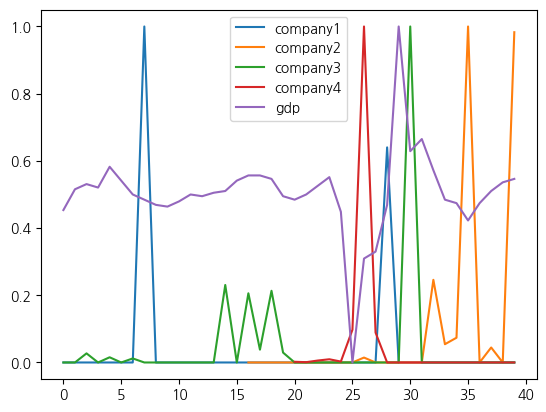

In [ ]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(cr_df)
normalized_df = pd.DataFrame(normalized_data, columns=cr_df.columns)
normalized_df.plot()

In [ ]:
normalized_df.mean()

company1    0.041004
company2    0.100674
company3    0.044302
company4    0.060372
gdp         0.504510
dtype: float64

In [ ]:
print(normalized_df.corr().iloc[-1])

company1   -0.045407
company2   -0.025982
company3    0.177916
company4   -0.323547
gdp         1.000000
Name: gdp, dtype: float64


<Axes: >

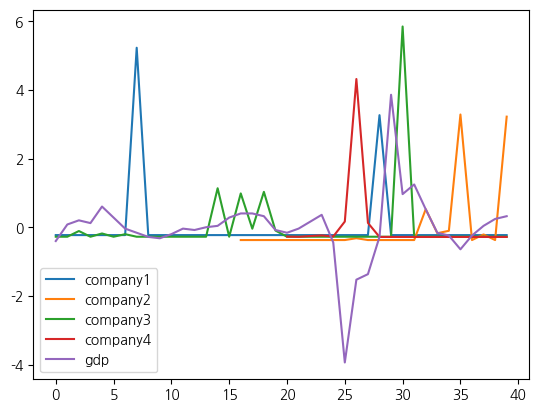

In [ ]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(cr_df)
normalized_df = pd.DataFrame(normalized_data, columns=cr_df.columns)
normalized_df.plot()

In [ ]:
normalized_df.corr().iloc[-1]

company1   -0.045407
company2   -0.025982
company3    0.177916
company4   -0.323547
gdp         1.000000
Name: gdp, dtype: float64

# 노트

In [ ]:
################## 실험용 ###################
r = 0.041
series_container = {}
for i in range(len(company_lst)-3):
  company_i = process_company_data(data_dict, company_lst[i], var_name_lst_no_date, i)
  company_i_profit_series = company_i['영업이익']
  company_i_debt_series = company_i['부채']
  company_i_market_series = company_i['시가총액']

  # recovery rate 계산
  recovery_rate_series_i = company_i_profit_series / company_i_debt_series
  recovery_rate_series_i = recovery_rate_series_i.clip(upper=1, lower=0)
  # 부도확률 계산
  STD_V = company_i_market_series.std()
  R = r
  T = company_i_market_series.shape[0]
  tmp = []
  for V, K in zip(company_i_market_series, company_i_debt_series):
    d1 = ((np.log(V)-np.log(K)) + (R + 0.5 * STD_V**2) * T) / (STD_V * np.sqrt(T))
    d2 = d1 - STD_V * np.sqrt(T)
    # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
    def_prob = norm.logcdf(d2)
    tmp.append(def_prob)
  print(tmp) # 값은 계산이 됨
  company_i_default_rate_series = pd.Series(tmp, index=company_i.index)
  company_i_default_rate_series = (company_i_default_rate_series/company_i_default_rate_series.iloc[0])
  # print(company_i_default_rate_series)
  company_i_default_rate_series = company_i_default_rate_series.clip(upper=1, lower=0)
  # EAD 계산
  company_i_ead_series = company_i_debt_series / company_i_debt_series.iloc[0]
  # print(company_i_ead_series)
  # credit risk 계산
  company_i_cr = company_i_default_rate_series * recovery_rate_series_i * company_i_ead_series
  # 데이터프레임 생성을 위한 리스트에 cr 시리즈를 붙인다.
  series_container[company_lst[i]] = company_i_cr

# 데이터프레임 생성
# df = pd.DataFrame({'company1':series_container[0],'company2':series_container[1],'company3':series_container[2],'company4':series_container[3]})
# df

[-28118862.572477214, -28118863.009857435, -28118863.34712388, -28118863.44336497, -28118863.55959773, -28118863.642169435, -28118863.691355832, -28118863.729124844, -28118863.768566217, -28118863.804824255, -28118863.837055326, -28118865.027964164, -28118865.02203895, -28118865.170801826, -28118865.111216456, -28118865.090863556, -28118865.095137935, -28118865.473932438, -28118865.44944502, -28118865.46666648, -28118865.971593603, -28118865.91212694, -28118865.912910163, -28118865.93518214, -28118866.158632927, -28118866.91159487, -28118866.270932768, -28118865.913349368, -28118865.54162401, -28118865.510464266, -28118866.279728353, -28118866.124641497, -28118866.11331889, -28118866.088048052, -28118866.84725828, -28118866.913425382, -28118867.241207674, -28118866.60329829, -28118866.56475496, -28118866.910283033]


In [ ]:
profit = []
debt = []
for i in range(len(company_lst)):
  company_i = process_company_data(data_dict, company_lst[i], var_name_lst_no_date, i)
  company_i_profit_series = company_i['영업이익']
  company_i_debt_series = company_i['부채']
  # company_i_market_series = company_i['시가총액']
  profit.append(company_i_profit_series)
  debt.append(company_i_debt_series)

company_i_profit_series = pd.Series(profit)
company_i_debt_series = pd.Series(profit)
recovery_rate_series_i = company_i_profit_series / company_i_debt_series
# recovery_rate_series_i = recovery_rate_series_i.clip(upper=1, lower=0)
profit
# recovery_rate_series_i

[기간
 2014-03-01      -5.748278
 2014-06-01     -11.016639
 2014-09-01     -28.697663
 2014-12-01      -5.343051
 2015-03-01      -6.058581
 2015-06-01      -5.975879
 2015-09-01     -36.644815
 2015-12-01     295.470109
 2016-03-01     -57.837899
 2016-06-01    -143.082139
 2016-09-01    -188.503708
 2016-12-01    -120.092014
 2017-03-01     -71.332209
 2017-06-01     -57.837899
 2017-09-01    -206.225201
 2017-12-01    -103.413058
 2018-03-01    -107.945519
 2018-06-01    -152.545091
 2018-09-01    -412.287849
 2018-12-01    -281.693878
 2019-03-01    -198.325851
 2019-06-01     -88.775448
 2019-09-01    -342.542735
 2019-12-01     -55.865540
 2020-03-01     -24.417519
 2020-06-01    -116.725804
 2020-09-01    -149.909484
 2020-12-01    -125.914846
 2021-03-01      46.955430
 2021-06-01    -205.275687
 2021-09-01    -779.425186
 2021-12-01     -10.569721
 2022-03-01    -112.999180
 2022-06-01    -106.890896
 2022-09-01   -2707.192419
 2022-12-01    -422.287890
 2023-03-01     -10.5697

In [ ]:
company2 = data_dict['company3']
company2 = company2[var_name_lst_no_date[2]]
company2

,영업이익3,부채3,시가총액3
기간,,,
2013-03-01,0.000000,0.000000,1812.461490
2013-06-01,0.000000,0.000000,1562.744574
2013-09-01,0.000000,0.000000,2215.230710
2013-12-01,0.000000,0.000000,1107.615355
2014-03-01,-2.924046,231.486445,1308.999965
2014-06-01,-11.364695,282.256362,1445.941500
2014-09-01,6.581411,225.986545,2416.615320
2014-12-01,-18.951297,251.494538,2517.307625
2015-03-01,3.754598,208.394199,1812.461490


In [ ]:
# company1
# company1.plot()
company2_profit_series = company2['영업이익3']
company2_debt_series = company2['부채3']
company2_market_series = company2['시가총액3']

In [ ]:
# Recovery Rate 계산
# company1_profit_norm = (company1_profit_series / company1_profit_series[0])
recovery_rate_series = company2_profit_series / company2_debt_series
# recovery_rate의 값이 음수면 영업이익이 적자이므로 사실상 0. 1보다 크면 그냥 1임. 그러므로 LGD는 0이 됨.
recovery_rate_series = recovery_rate_series.clip(upper=1, lower=0)
recovery_rate_series

기간
2013-03-01         NaN
2013-06-01         NaN
2013-09-01         NaN
2013-12-01         NaN
2014-03-01    0.000000
2014-06-01    0.000000
2014-09-01    0.029123
2014-12-01    0.000000
2015-03-01    0.018017
2015-06-01    0.000000
2015-09-01    0.020594
2015-12-01    0.000000
2016-03-01    0.000000
2016-06-01    0.000000
2016-09-01    0.000000
2016-12-01    0.000000
2017-03-01    0.000000
2017-06-01    0.000000
2017-09-01    0.060785
2017-12-01    0.000000
2018-03-01    0.065556
2018-06-01    0.010497
2018-09-01    0.055271
2018-12-01    0.006927
2019-03-01    0.000000
2019-06-01    0.000000
2019-09-01    0.000000
2019-12-01    0.000000
2020-03-01    0.000000
2020-06-01    0.000000
2020-09-01    0.000000
2020-12-01    0.000000
2021-03-01    0.000000
2021-06-01    0.000000
2021-09-01    0.069798
2021-12-01    0.000000
2022-03-01    0.000000
2022-06-01    0.000000
2022-09-01    0.000000
2022-12-01    0.000000
2023-03-01    0.000000
2023-06-01    0.000000
2023-09-01    0.000000
2023-12-

In [ ]:
# 개별 기업에 대해서 실험
# 부도확률 계산
STD_V = company2_market_series.std()
R = 0.041
T = company2_market_series.shape[0]
tmp = []
for V, K in zip(company2_market_series, company2_debt_series):
  d1 = (np.log(V) - np.log(K)) + ((R+(0.5*(STD_V**2)))*T) / (STD_V*np.sqrt(T))
  d2 = d1 - (STD_V*np.sqrt(T))
  # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
  def_prob = norm.logcdf(d2)
  tmp.append(def_prob)
#default_dict = {'부도율':tmp}
company2_default_rate_series = pd.Series(tmp, index=company2.index)
# mt_df_company1 = pd.DataFrame(def_dict, index=company1.index)
# 부도확률
company2_default_rate_series = 1-(company2_default_rate_series/company2_default_rate_series.iloc[0]) ############### 다른 점
company2_default_rate_series = company2_default_rate_series.clip(upper=1, lower=0)
company2_default_rate_series
# default_rate_df_company1.plot()
# company2_default_rate_series.plot()

기간
2013-03-01    NaN
2013-06-01    NaN
2013-09-01    NaN
2013-12-01    NaN
2014-03-01    1.0
2014-06-01    1.0
2014-09-01    1.0
2014-12-01    1.0
2015-03-01    1.0
2015-06-01    1.0
2015-09-01    1.0
2015-12-01    1.0
2016-03-01    1.0
2016-06-01    1.0
2016-09-01    1.0
2016-12-01    1.0
2017-03-01    1.0
2017-06-01    1.0
2017-09-01    1.0
2017-12-01    1.0
2018-03-01    1.0
2018-06-01    1.0
2018-09-01    1.0
2018-12-01    1.0
2019-03-01    1.0
2019-06-01    1.0
2019-09-01    1.0
2019-12-01    1.0
2020-03-01    1.0
2020-06-01    1.0
2020-09-01    1.0
2020-12-01    1.0
2021-03-01    1.0
2021-06-01    1.0
2021-09-01    1.0
2021-12-01    1.0
2022-03-01    1.0
2022-06-01    1.0
2022-09-01    1.0
2022-12-01    1.0
2023-03-01    1.0
2023-06-01    1.0
2023-09-01    1.0
2023-12-01    1.0
dtype: float64

In [ ]:
# 개별 기업에 대해서 실험
# 부도확률 계산
STD_V = company2_market_series.std()
R = 0.041
T = company2_market_series.shape[0]
tmp = []
for V, K in zip(company2_market_series, company2_debt_series):
  d1 = (np.log(V) - np.log(K)) + ((R+(0.5*(STD_V**2)))*T) / (STD_V*np.sqrt(T))
  d2 = d1 - (STD_V*np.sqrt(T))
  # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
  def_prob = norm.logcdf(d2)
  tmp.append(def_prob)
#default_dict = {'부도율':tmp}
company2_default_rate_series = pd.Series(tmp, index=company2.index)
# mt_df_company1 = pd.DataFrame(def_dict, index=company1.index)
# 부도확률
company2_default_rate_series = (company2_default_rate_series/company2_default_rate_series.iloc[0])
company2_default_rate_series = company2_default_rate_series.clip(upper=1, lower=0)
company2_default_rate_series

기간
2013-03-01    NaN
2013-06-01    NaN
2013-09-01    NaN
2013-12-01    NaN
2014-03-01    0.0
2014-06-01    0.0
2014-09-01    0.0
2014-12-01    0.0
2015-03-01    0.0
2015-06-01    0.0
2015-09-01    0.0
2015-12-01    0.0
2016-03-01    0.0
2016-06-01    0.0
2016-09-01    0.0
2016-12-01    0.0
2017-03-01    0.0
2017-06-01    0.0
2017-09-01    0.0
2017-12-01    0.0
2018-03-01    0.0
2018-06-01    0.0
2018-09-01    0.0
2018-12-01    0.0
2019-03-01    0.0
2019-06-01    0.0
2019-09-01    0.0
2019-12-01    0.0
2020-03-01    0.0
2020-06-01    0.0
2020-09-01    0.0
2020-12-01    0.0
2021-03-01    0.0
2021-06-01    0.0
2021-09-01    0.0
2021-12-01    0.0
2022-03-01    0.0
2022-06-01    0.0
2022-09-01    0.0
2022-12-01    0.0
2023-03-01    0.0
2023-06-01    0.0
2023-09-01    0.0
2023-12-01    0.0
dtype: float64

In [ ]:
# 해당 산업 내 기업들의 credit risk를 계산해 하나의 데이터프레임으로 만드는 함수. 값들은 전부 정규화된다.
def cal_credit_risk_norm(r, data_dict, company_lst, var_name_lst_no_date):
  series_container = []
  for i in range(len(company_lst)):
    company_i = process_company_data(data_dict, company_lst[i], var_name_lst_no_date, i)
    company_i_profit_series = company_i['영업이익']
    company_i_debt_series = company_i['부채']
    company_i_market_series = company_i['시가총액']

    # 정규화를 위한 scaler
    scaler = MinMaxScaler()

    # recovery rate 계산
    recovery_rate_series_i = company_i_profit_series / company_i_debt_series
    recovery_rate_series_i = recovery_rate_series_i.clip(upper=1, lower=0)
    # 부도확률 계산
    STD_V = company_i_market_series.std()
    R = r
    T = company_i_market_series.shape[0]
    tmp = []
    for V, K in zip(company_i_market_series, company_i_debt_series):
      d1 = (np.log(V/K) + (R + 0.5 * STD_V**2) * T) / (STD_V * np.sqrt(T))
      d2 = d1 - STD_V * np.sqrt(T)
      # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
      def_prob = norm.logcdf(d2)
      tmp.append(def_prob)
    company_i_default_rate_series = pd.Series(tmp, index=company_i.index)
    company_i_default_rate_series = (company_i_default_rate_series/company_i_default_rate_series.iloc[0])
    company_i_default_rate_series = company_i_default_rate_series.clip(upper=1, lower=0)
    # EAD 계산
    company_i_ead_series = company_i_debt_series / company_i_debt_series.iloc[0]
    # credit risk 계산
    company_i_cr = company_i_default_rate_series * recovery_rate_series_i * company_i_ead_series
    # 데이터프레임 생성을 위한 리스트에 cr 시리즈를 붙인다.
    series_container.append(company_i_cr)

  # 데이터프레임 생성
  df = pd.DataFrame({'company1':series_container[0],'company2':series_container[1],'company3':series_container[2],'company4':series_container[3]})
  # 데이터프레임 반환
  return df

In [ ]:
# 개별 기업에 대해서 실험
# 부도확률 계산
STD_V = company2_market_series.std()
R = 0.041
T = company2_market_series.shape[0]
tmp = []
for V, K in zip(company2_market_series, company2_debt_series):
  d1 = (np.log(V) - np.log(K)) + ((R+(0.5*(STD_V**2)))*T) / (STD_V*np.sqrt(T))
  d2 = d1 - (STD_V*np.sqrt(T))
  # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
  def_prob = norm.logcdf(d2)
  tmp.append(def_prob)
#default_dict = {'부도율':tmp}
company2_default_rate_series = pd.Series(tmp, index=company2.index)
# mt_df_company1 = pd.DataFrame(def_dict, index=company1.index)
# 부도확률
company2_default_rate_series = (company2_default_rate_series/company2_default_rate_series.iloc[0])
company2_default_rate_series = company2_default_rate_series.clip(upper=1, lower=0)
company2_default_rate_series

기간
2013-03-01    NaN
2013-06-01    NaN
2013-09-01    NaN
2013-12-01    NaN
2014-03-01    0.0
2014-06-01    0.0
2014-09-01    0.0
2014-12-01    0.0
2015-03-01    0.0
2015-06-01    0.0
2015-09-01    0.0
2015-12-01    0.0
2016-03-01    0.0
2016-06-01    0.0
2016-09-01    0.0
2016-12-01    0.0
2017-03-01    0.0
2017-06-01    0.0
2017-09-01    0.0
2017-12-01    0.0
2018-03-01    0.0
2018-06-01    0.0
2018-09-01    0.0
2018-12-01    0.0
2019-03-01    0.0
2019-06-01    0.0
2019-09-01    0.0
2019-12-01    0.0
2020-03-01    0.0
2020-06-01    0.0
2020-09-01    0.0
2020-12-01    0.0
2021-03-01    0.0
2021-06-01    0.0
2021-09-01    0.0
2021-12-01    0.0
2022-03-01    0.0
2022-06-01    0.0
2022-09-01    0.0
2022-12-01    0.0
2023-03-01    0.0
2023-06-01    0.0
2023-09-01    0.0
2023-12-01    0.0
dtype: float64

In [ ]:
company1 = data_dict['company1'][['영업이익1', '부채1', '시가총액1']]
selected_vars = var_name_lst_no_date[0]
company1[selected_vars[0]]

기간
2013-03-01      -0.984007
2013-06-01      -8.714422
2013-09-01      -1.889657
2013-12-01      -5.554220
2014-03-01      -5.748278
2014-06-01     -11.016639
2014-09-01     -28.697663
2014-12-01      -5.343051
2015-03-01      -6.058581
2015-06-01      -5.975879
2015-09-01     -36.644815
2015-12-01     295.470109
2016-03-01     -57.837899
2016-06-01    -143.082139
2016-09-01    -188.503708
2016-12-01    -120.092014
2017-03-01     -71.332209
2017-06-01     -57.837899
2017-09-01    -206.225201
2017-12-01    -103.413058
2018-03-01    -107.945519
2018-06-01    -152.545091
2018-09-01    -412.287849
2018-12-01    -281.693878
2019-03-01    -198.325851
2019-06-01     -88.775448
2019-09-01    -342.542735
2019-12-01     -55.865540
2020-03-01     -24.417519
2020-06-01    -116.725804
2020-09-01    -149.909484
2020-12-01    -125.914846
2021-03-01      46.955430
2021-06-01    -205.275687
2021-09-01    -779.425186
2021-12-01     -10.569721
2022-03-01    -112.999180
2022-06-01    -106.890896
2022-09-0

In [ ]:
company1 = process_company_data(data_dict, company_lst[0], var_name_lst_no_date, 0)
company1

,영업이익,부채,시가총액
기간,,,
2014-03-01,-5.748278,7.256745,7497.696799
2014-06-01,-11.016639,17.403856,7497.696799
2014-09-01,-28.697663,34.165786,7497.696799
2014-12-01,-5.343051,41.417642,7497.696799
2015-03-01,-6.058581,52.256926,7497.696799
2015-06-01,-5.975879,61.640299,7497.696799
2015-09-01,-36.644815,68.012307,7497.696799
2015-12-01,295.470109,73.348839,7497.696799
2016-03-01,-57.837899,79.369125,7497.696799


In [ ]:
# Sample DataFrame
data = {'A': [1, 2, 3, 4, 5], 'B': [10, 20, 30, 40, 50]}
df = pd.DataFrame(data)

# Normalization
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)

normalized_df = pd.DataFrame(normalized_data, columns=df.columns)
print(normalized_df)

      A     B
0  0.00  0.00
1  0.25  0.25
2  0.50  0.50
3  0.75  0.75
4  1.00  1.00


In [ ]:
# Sample DataFrame
data = {'A': [1, 2, 3, 4, 5], 'B': [10, 20, 30, 40, 50]}
df = pd.DataFrame(data)

# Standardization
scaler = StandardScaler()
standardized_data = scaler.fit_transform(df)

standardized_df = pd.DataFrame(standardized_data, columns=df.columns)
print(standardized_df)

          A         B
0 -1.414214 -1.414214
1 -0.707107 -0.707107
2  0.000000  0.000000
3  0.707107  0.707107
4  1.414214  1.414214
